In [2]:
import numpy as np
import itertools
%matplotlib notebook
#%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
from sklearn import datasets
iris = datasets.load_iris()
list(iris.keys())
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

(150, 3) (150,)


<IPython.core.display.Javascript object>


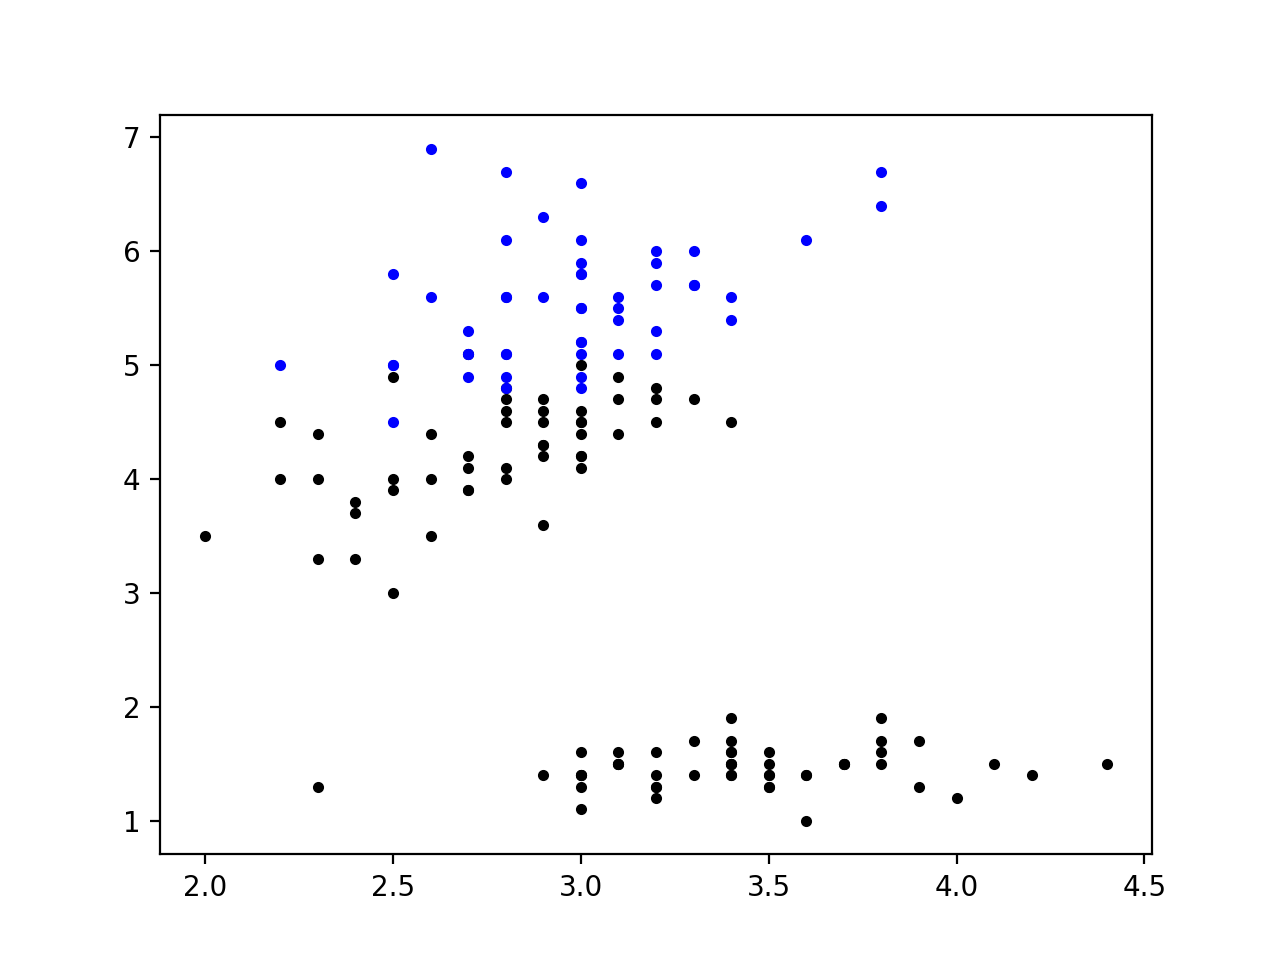

In [6]:
def one_hot(
  y, #vector of size N class-labels [1,...,C]
):
    N, C = y.shape[0], np.max(y)+1
    y_hot = np.zeros((N, C))
    y_hot[np.arange(N), y] = 1
    return y_hot

Xd = iris["data"][:, (1,2)]  # petal width
Xd = np.vstack((Xd.T, np.ones(Xd.shape[0]))).T
yd = (iris["target"] == 2).astype(np.int)  # 1 if Iris-Virginica, else 0
y = iris["target"]
Yd = one_hot(iris["target"])
print(Xd.shape, yd.shape)
fig, ax = plt.subplots()
plt.plot(Xd[yd==0,0], Xd[yd==0,1], 'k.' )
plt.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )


In [49]:
def logistic(z):
    return 1./(1. + np.exp(-z))

def ce(y, yh):
    loss = -np.mean(y * np.log(yh) + (1-y)*np.log(1-yh))
    return loss

def cost(X,y,w, lamb2=0, lamb1=0):
    yh = np.dot(X, w)
    J = np.mean(y * np.log1p(np.exp(-yh)) + (1-y) * np.log1p(np.exp(yh))) \
        + lamb2 * np.dot(w[:-1],w[:-1])/2 + lamb1 * np.sum(np.abs(w[:-1]))
    #J = ce(y,yh)
    return J

def gradient(X, y, w, lamb2=0, lamb1=0):
    N,D = X.shape
    yh = logistic(np.dot(X, w))
    grad = np.dot(X.T, yh - y)/N
    grad[:-1] += lamb2 * w[:-1] + lamb1 * np.sign(w[:-1])
    return grad
    
def GD(X,y,lr=1,eps=1e-18, max_iters=100000, lamb2=0, lamb1=0):
    
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        g = gradient(X, y, w, lamb1=lamb1, lamb2=lamb2)
        w = w - lr*g/np.sqrt(t+1)
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist

def SGD(X,y,lr=.01,eps=1e-18, max_iters=8000, lamb2=0, lamb1=0):
    
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(1))
        g = gradient(X[i,:], y[i], w, lamb1=lamb1, lamb2=lamb2)
        #lr = 1./(1+(t**.5))
        w = w - lr*g
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist

def Momentum(X,y,lr=.1,eps=1e-18, max_iters=8000, beta=.99, lamb2=0, lamb1=0):
    
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    dw = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(N))
        g = gradient(X[i,:], y[i], w, lamb1=lamb1, lamb2=lamb2)
        dw = (1-beta)*g + beta * dw
        w = w - lr*dw
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist


def Adagrad(X,y,lr=.1,eps=1e-18, max_iters=80000, lamb2=0, lamb1=0):
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    s = 1e-8
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(1))
        g = gradient(X[i,:], y[i], w, lamb1=lamb1, lamb2=lamb2)
        s += g**2
        w = w - lr*g/(np.sqrt(s))
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist

def RMSProp(X,y,lr=.01,eps=1e-18, max_iters=8000, gamma=.9, lamb2=0, lamb1=0):
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    s = 0
    epsilon = 1e-8
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(1))
        g = gradient(X[i,:], y[i], w, lamb1=lamb1, lamb2=lamb2)
        s = gamma * s + (1-gamma)*(g**2)
        w = w - lr*g/(np.sqrt(s + epsilon))
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist


In [68]:
l1,l2 = 1., 0
w, w_hist = GD(Xd, yd, lamb1=l1, lamb2=l2)
print(w_hist.shape)

(100001, 2)


<IPython.core.display.Javascript object>


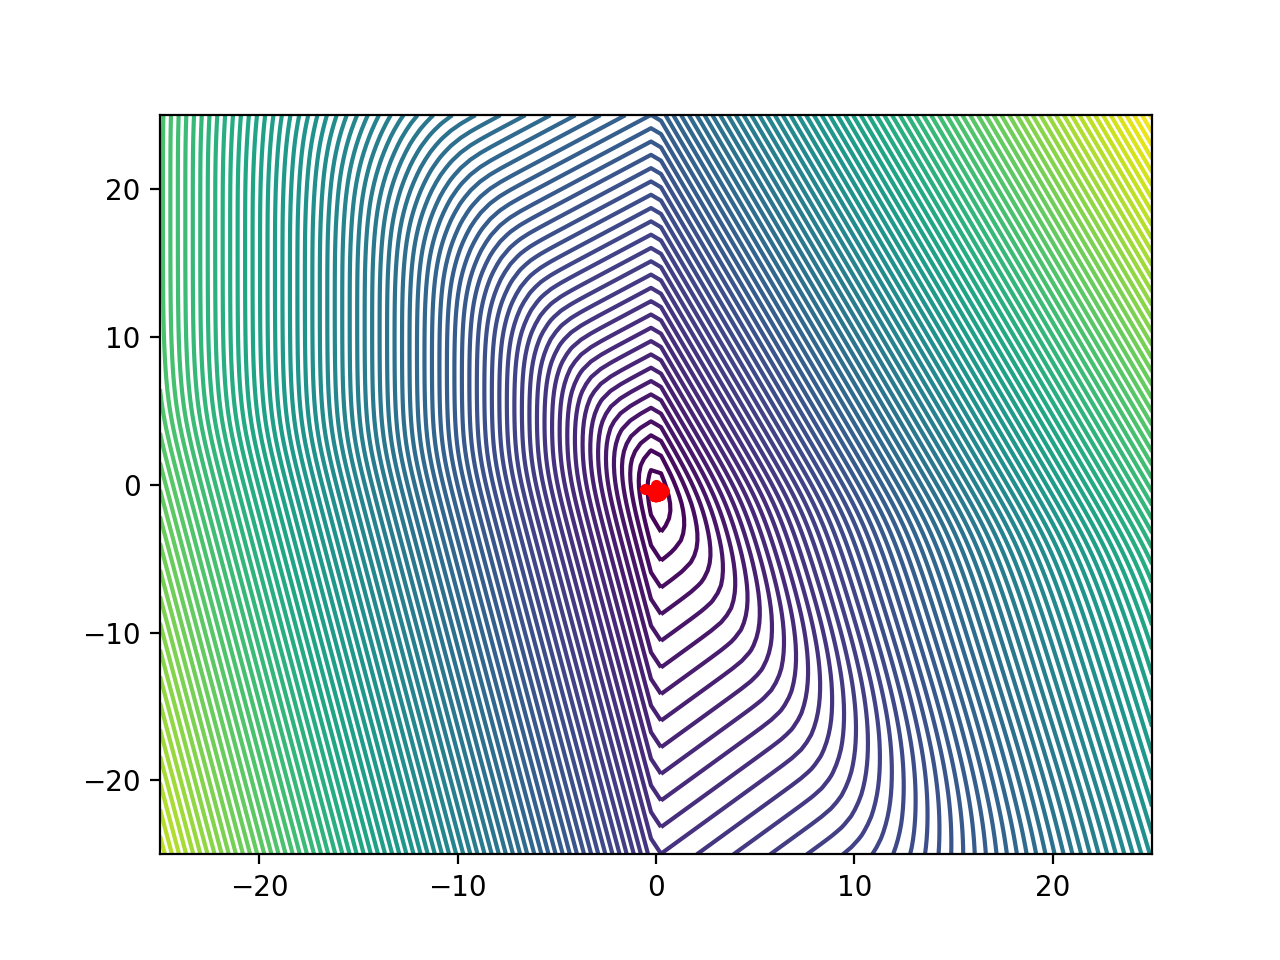

In [69]:
def plot_contour(f, xbound, ybound, contourf=False):
    xrange = np.linspace(xbound[0], xbound[1], 100)
    yrange = np.linspace(ybound[0], ybound[1], 100)
    Xg, Yg = np.meshgrid(xrange, yrange)
    Zg = np.zeros_like(Xg)
    for i,j in itertools.product(range(100), range(100)):
        Zg[i,j] = f(np.array([Xg[i,j], Yg[i,j]]))
    fig, ax = plt.subplots()
    if contourf:
        ax.contourf(Xg, Yg, Zg, 100)
    else:
        ax.contour(Xg, Yg, Zg, 100)
    return fig, ax

f = lambda alpha: cost(Xd,yd,alpha, lamb1=l1, lamb2=l2)
bmin, bmax = .9*np.min(w_hist, axis=1), 1.1*np.max(w_hist,axis=1)
fig, ax = plot_contour(f, [-25,25], [-25,25])#[bmin[0],bmax[0]], [bmin[1], bmax[1]])
#ax.plot(w_hist[-1,0]*0, w_hist[-1,1], 'rx',linewidth=.5)
ax.plot(w_hist[:,0], w_hist[:,1], 'r.')

plt.show()

<IPython.core.display.Javascript object>


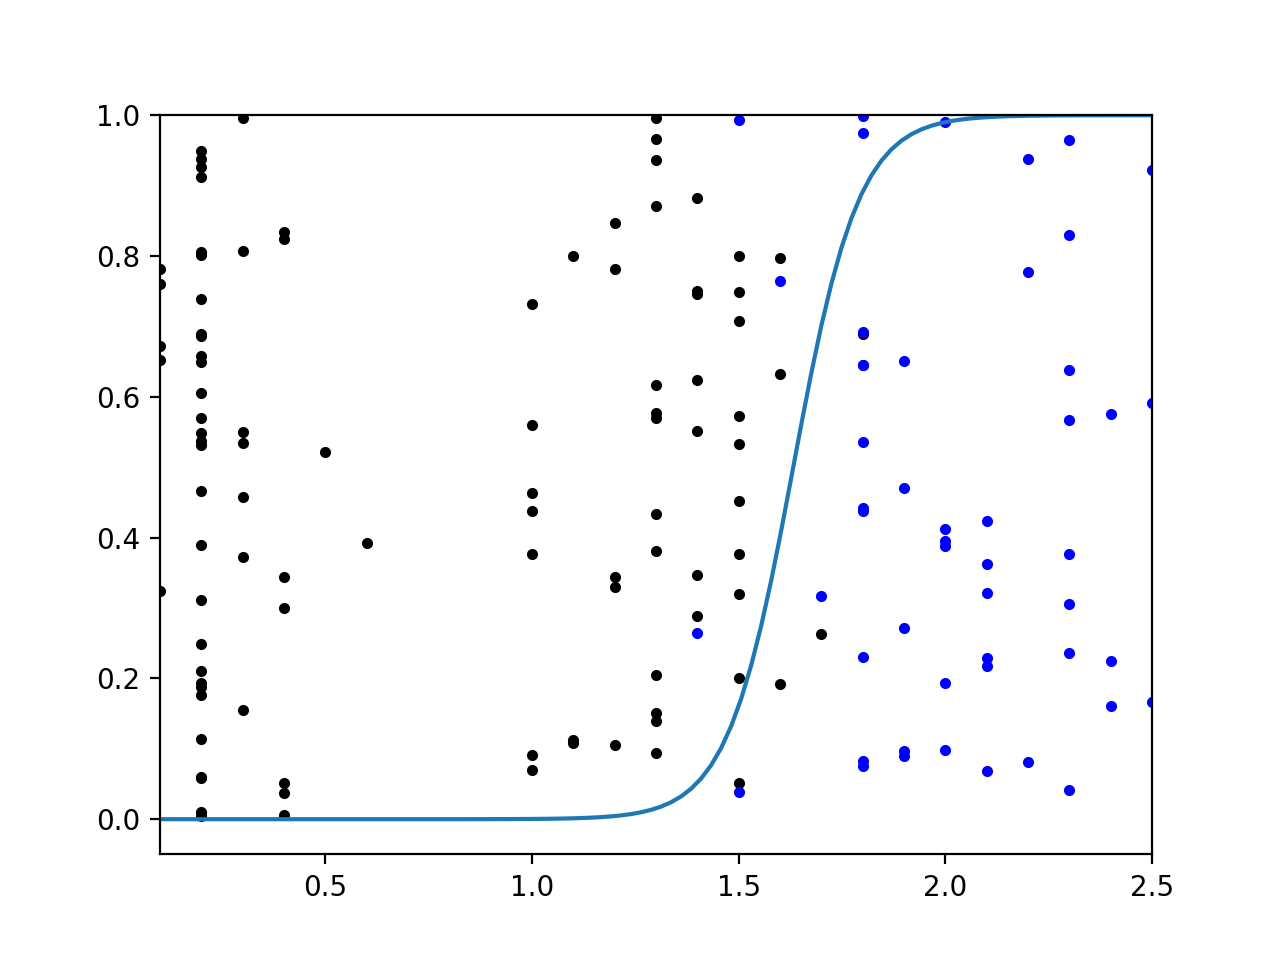

array([ 12.52920757, -20.44761679])

In [38]:
Xmin,Xmax = np.min(Xd, 0), np.max(Xd,0)
prob = lambda x: logistic(np.dot(x, w_hist[-1,:]))
plot_contour(prob, [Xmin[0],Xmax[0]], [Xmin[1],Xmax[1]], contourf=True)
plt.plot(Xd[yd==0,0], np.random.rand(np.sum(1-yd))*1, 'k.' )
plt.plot(Xd[yd==1,0], np.random.rand(np.sum(yd))*1, 'b.' )

#plt.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
#prob(Xd[yd==1,:])
xplot = np.linspace(Xmin[0], Xmax[0], 100)
xplot = np.vstack([xplot, np.ones(xplot.shape[0])]).T
plt.plot(xplot[:,0], prob(xplot))
w_hist[-1,:]

Linear regression
------------

<IPython.core.display.Javascript object>


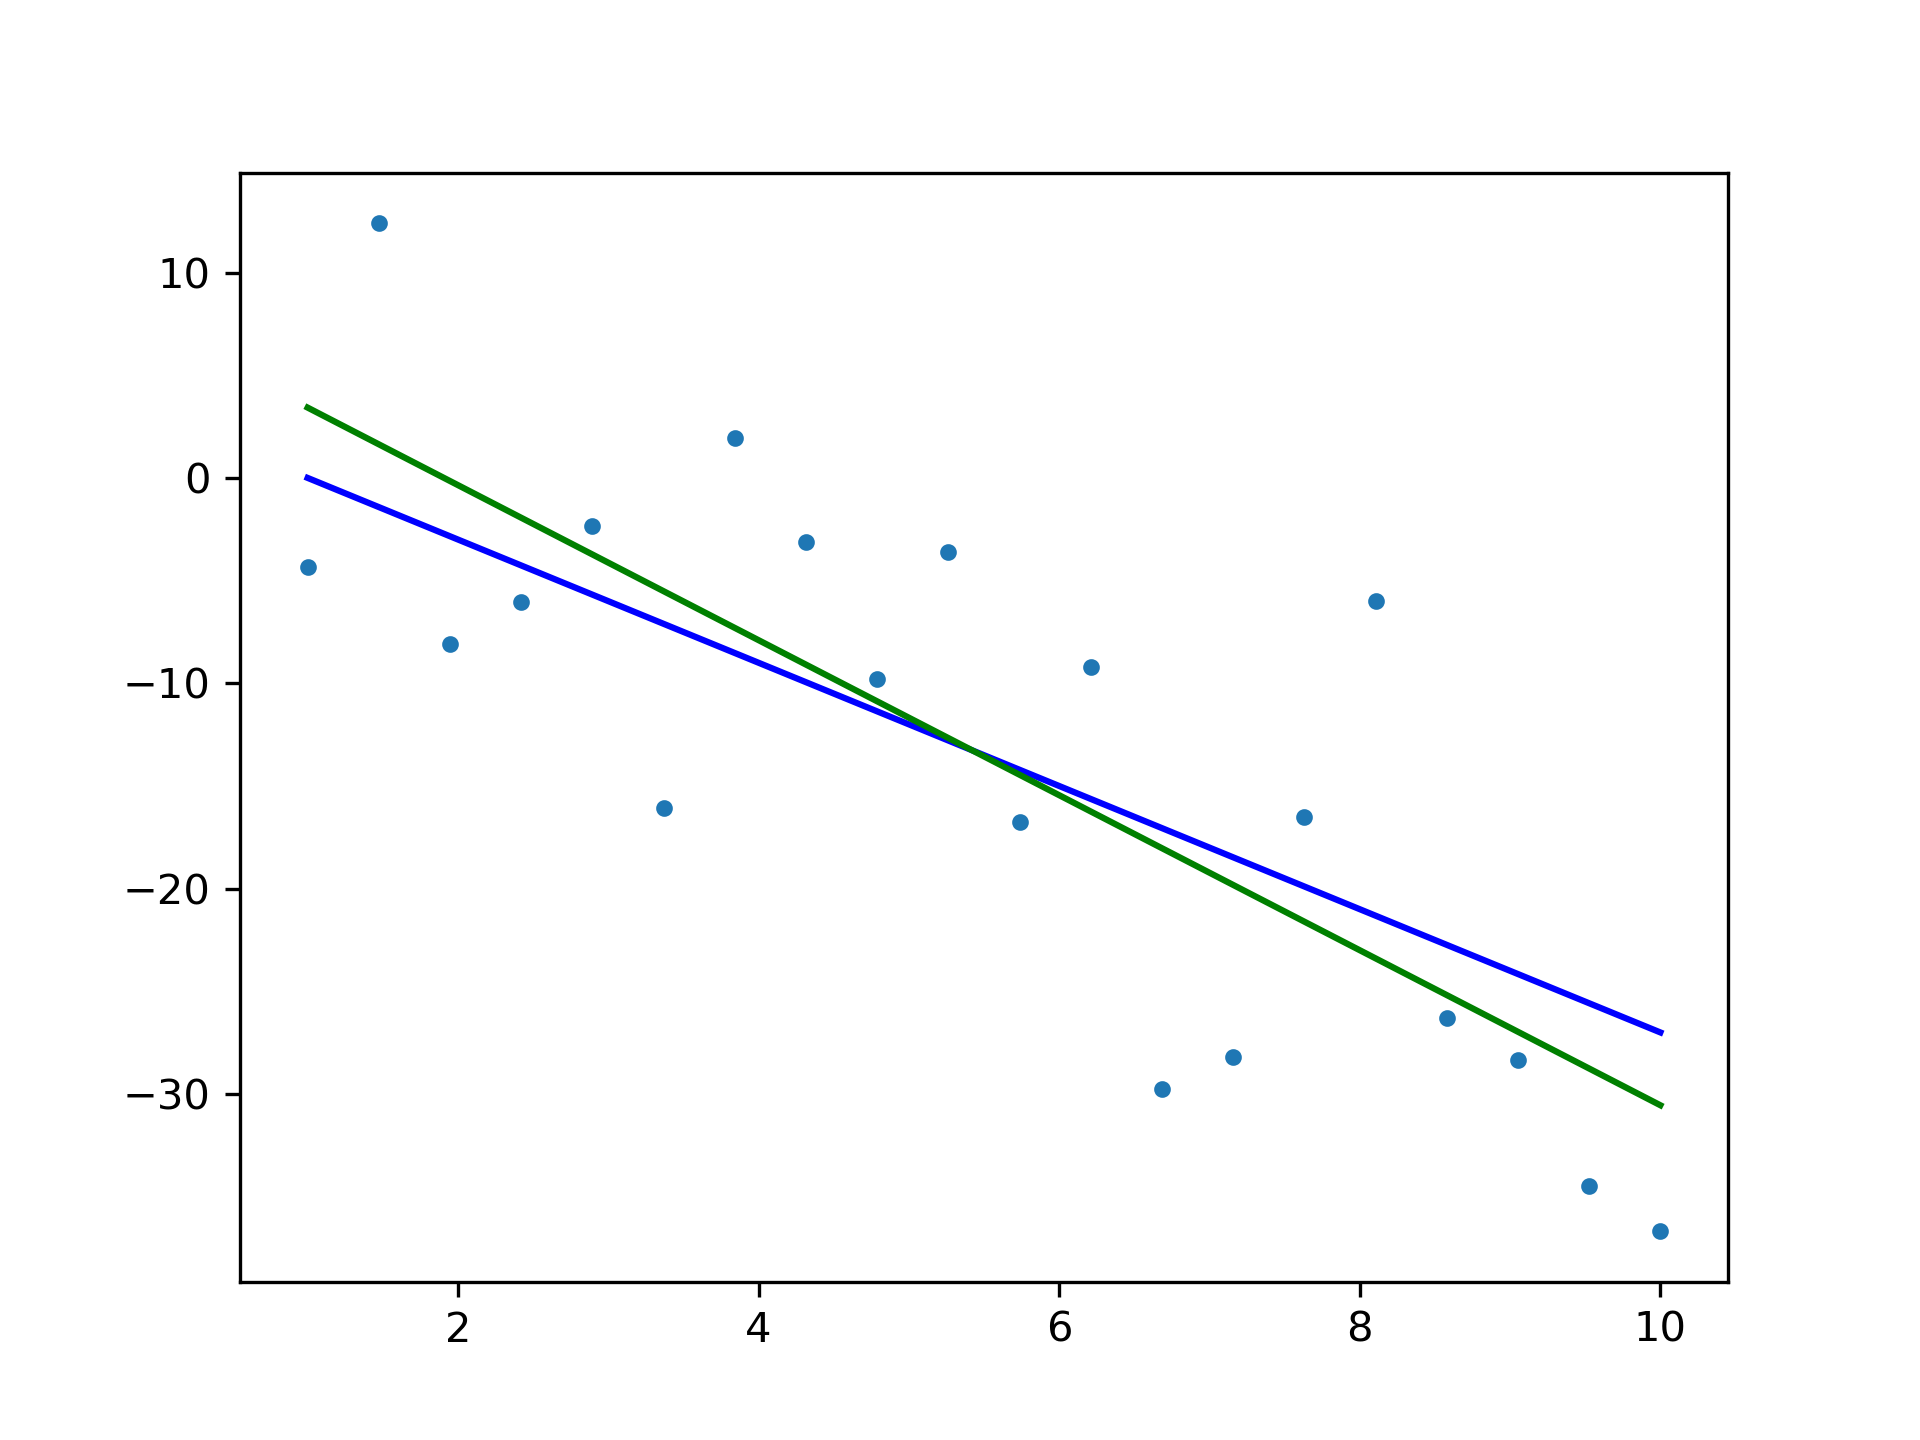

<ipython-input-19-fb2c649cefcb>:9: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [19]:
N = 20
x = np.linspace(1,10, N)
yt = -3*x + 3
y = -3*x + 3 + 10*np.random.randn(N)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x,yt, 'b-')
X = np.vstack([x,np.ones(N)]).T
w = np.linalg.lstsq(X, y)[0]
yh = np.dot(X,w)
plt.plot(x, yh, 'g-')

Linear regression GD
=======

<IPython.core.display.Javascript object>


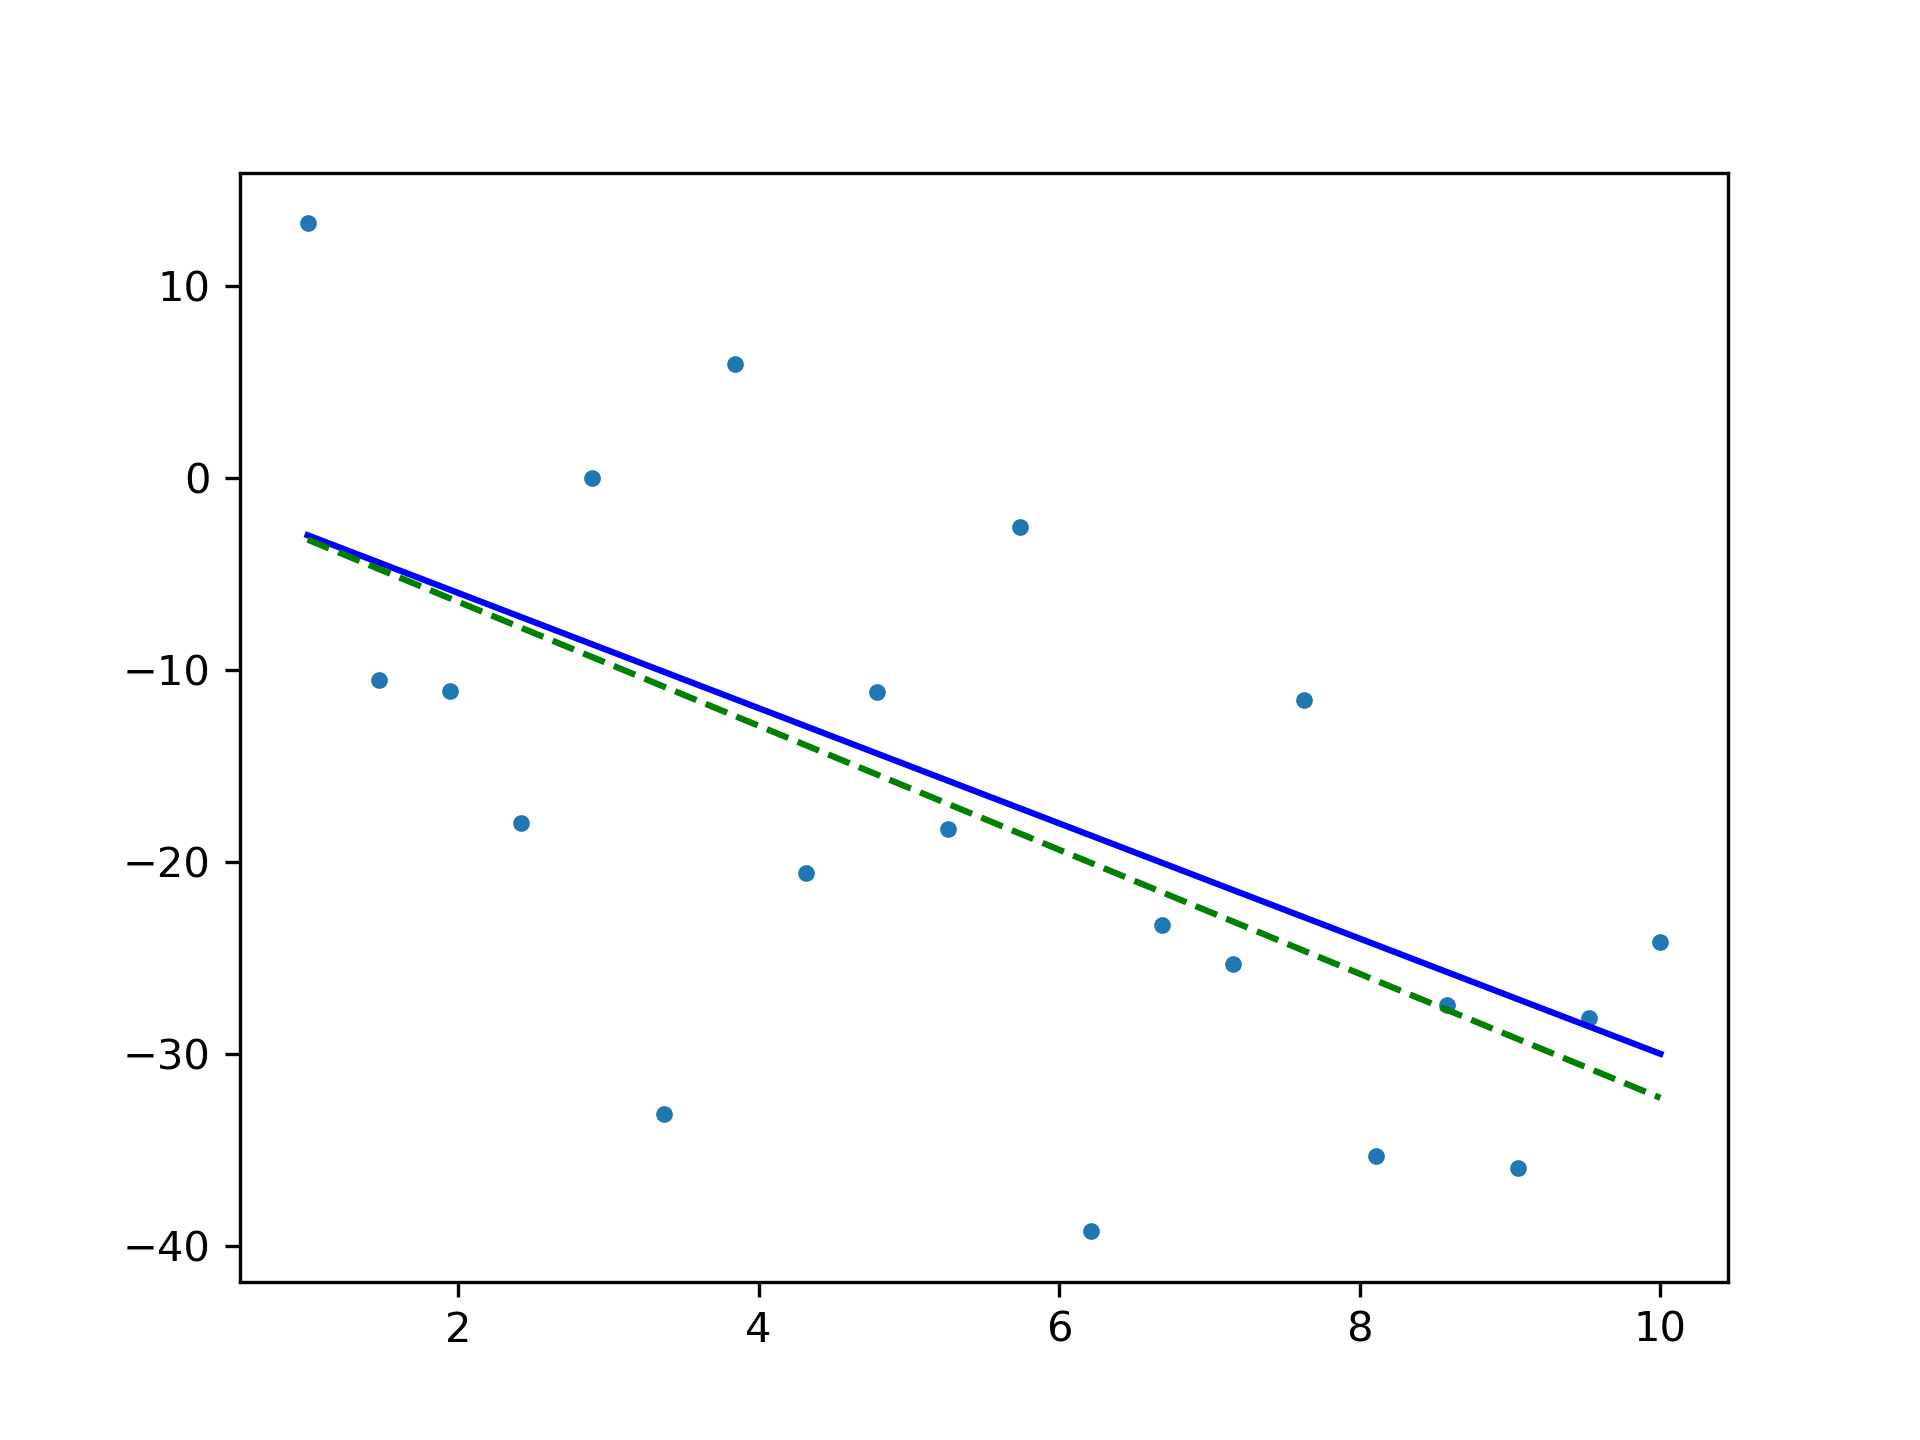

[-3.22919228]


<ipython-input-51-a519ecdf76eb>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(X, y)[0]


In [51]:
np.random.seed(1)
N = 20
x = np.linspace(1,10, N)
yt = -3*x
y = -3*x + 10*np.random.randn(N)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x,yt, 'b-')
X = x[:,None]
w = np.linalg.lstsq(X, y)[0]
yh = np.dot(X,w)
plt.plot(x, yh, 'g--')
print(w)

In [88]:
def cost(X,y,w):
    w= np.atleast_1d(w)
    yh = np.dot(X, w)
    J = .5*np.mean((yh - y)**2)
    #J = ce(y,yh)
    return J

def gradient(X, y, w):
    yh = np.dot(X, w)
    grad = np.dot(X.T, yh - y)/X.shape[0]
    return grad
    
def GD(X,y,lr=.06,eps=1e-2, max_iters=100):
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        g = gradient(X, y, w)
        w = w - g/(10*t+1.)
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist


def SGD(X,y,lr=.001,eps=1e-2, max_iters=100, bsize=1):
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N)
        g = gradient(X[[i],:], y[[i]], w)
        w = w - g/(10*t+1.)
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist


In [89]:
w, w_hist = SGD(X, y)
print(w_hist.shape)


(101, 1)


<IPython.core.display.Javascript object>


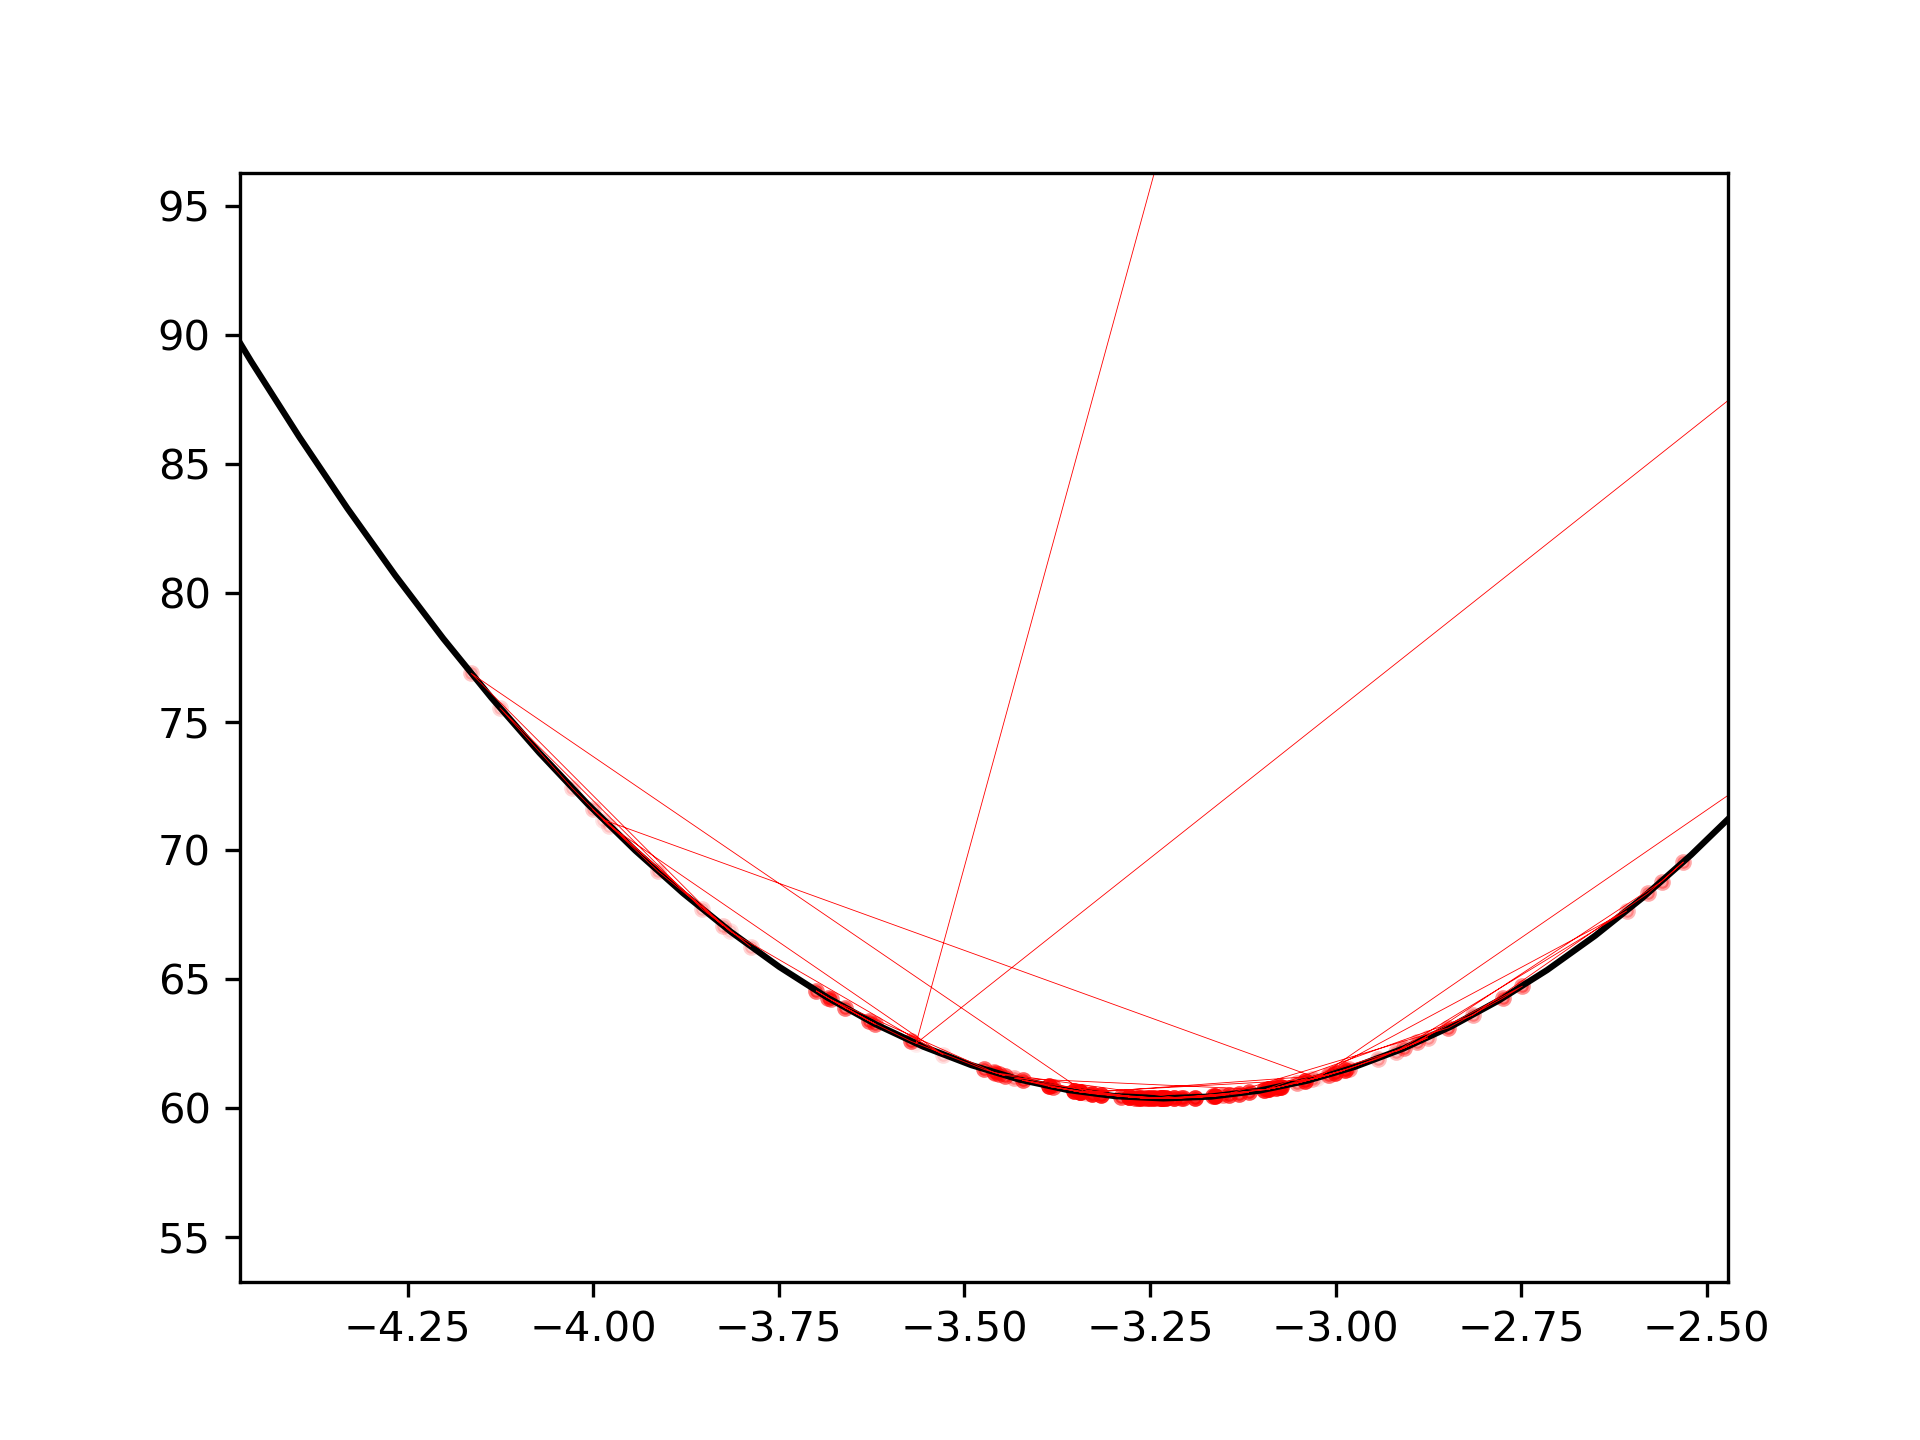

In [91]:
f = lambda alpha: cost(X,y,alpha)
ws = np.linspace(-6.4,0,100)
ws_costs = np.zeros_like(ws)
w_hist_costs = np.zeros_like(w_hist)
fig, ax = plt.subplots()
for t in range(ws.shape[0]):
    ws_costs[t] = f(ws[t])
for t in range(w_hist.shape[0]):
    w_hist_costs[t] = f(w_hist[t])
    ax.plot(w_hist[t], w_hist_costs[t],'.r', alpha=(t+1)/w_hist.shape[0])

ax.plot(ws, ws_costs, '-k', label="cost")
ax.plot(w_hist, w_hist_costs,'-r', linewidth=.2)
#ax.plot(w_hist, w_hist_costs,'.r')
plt.show()

<IPython.core.display.Javascript object>


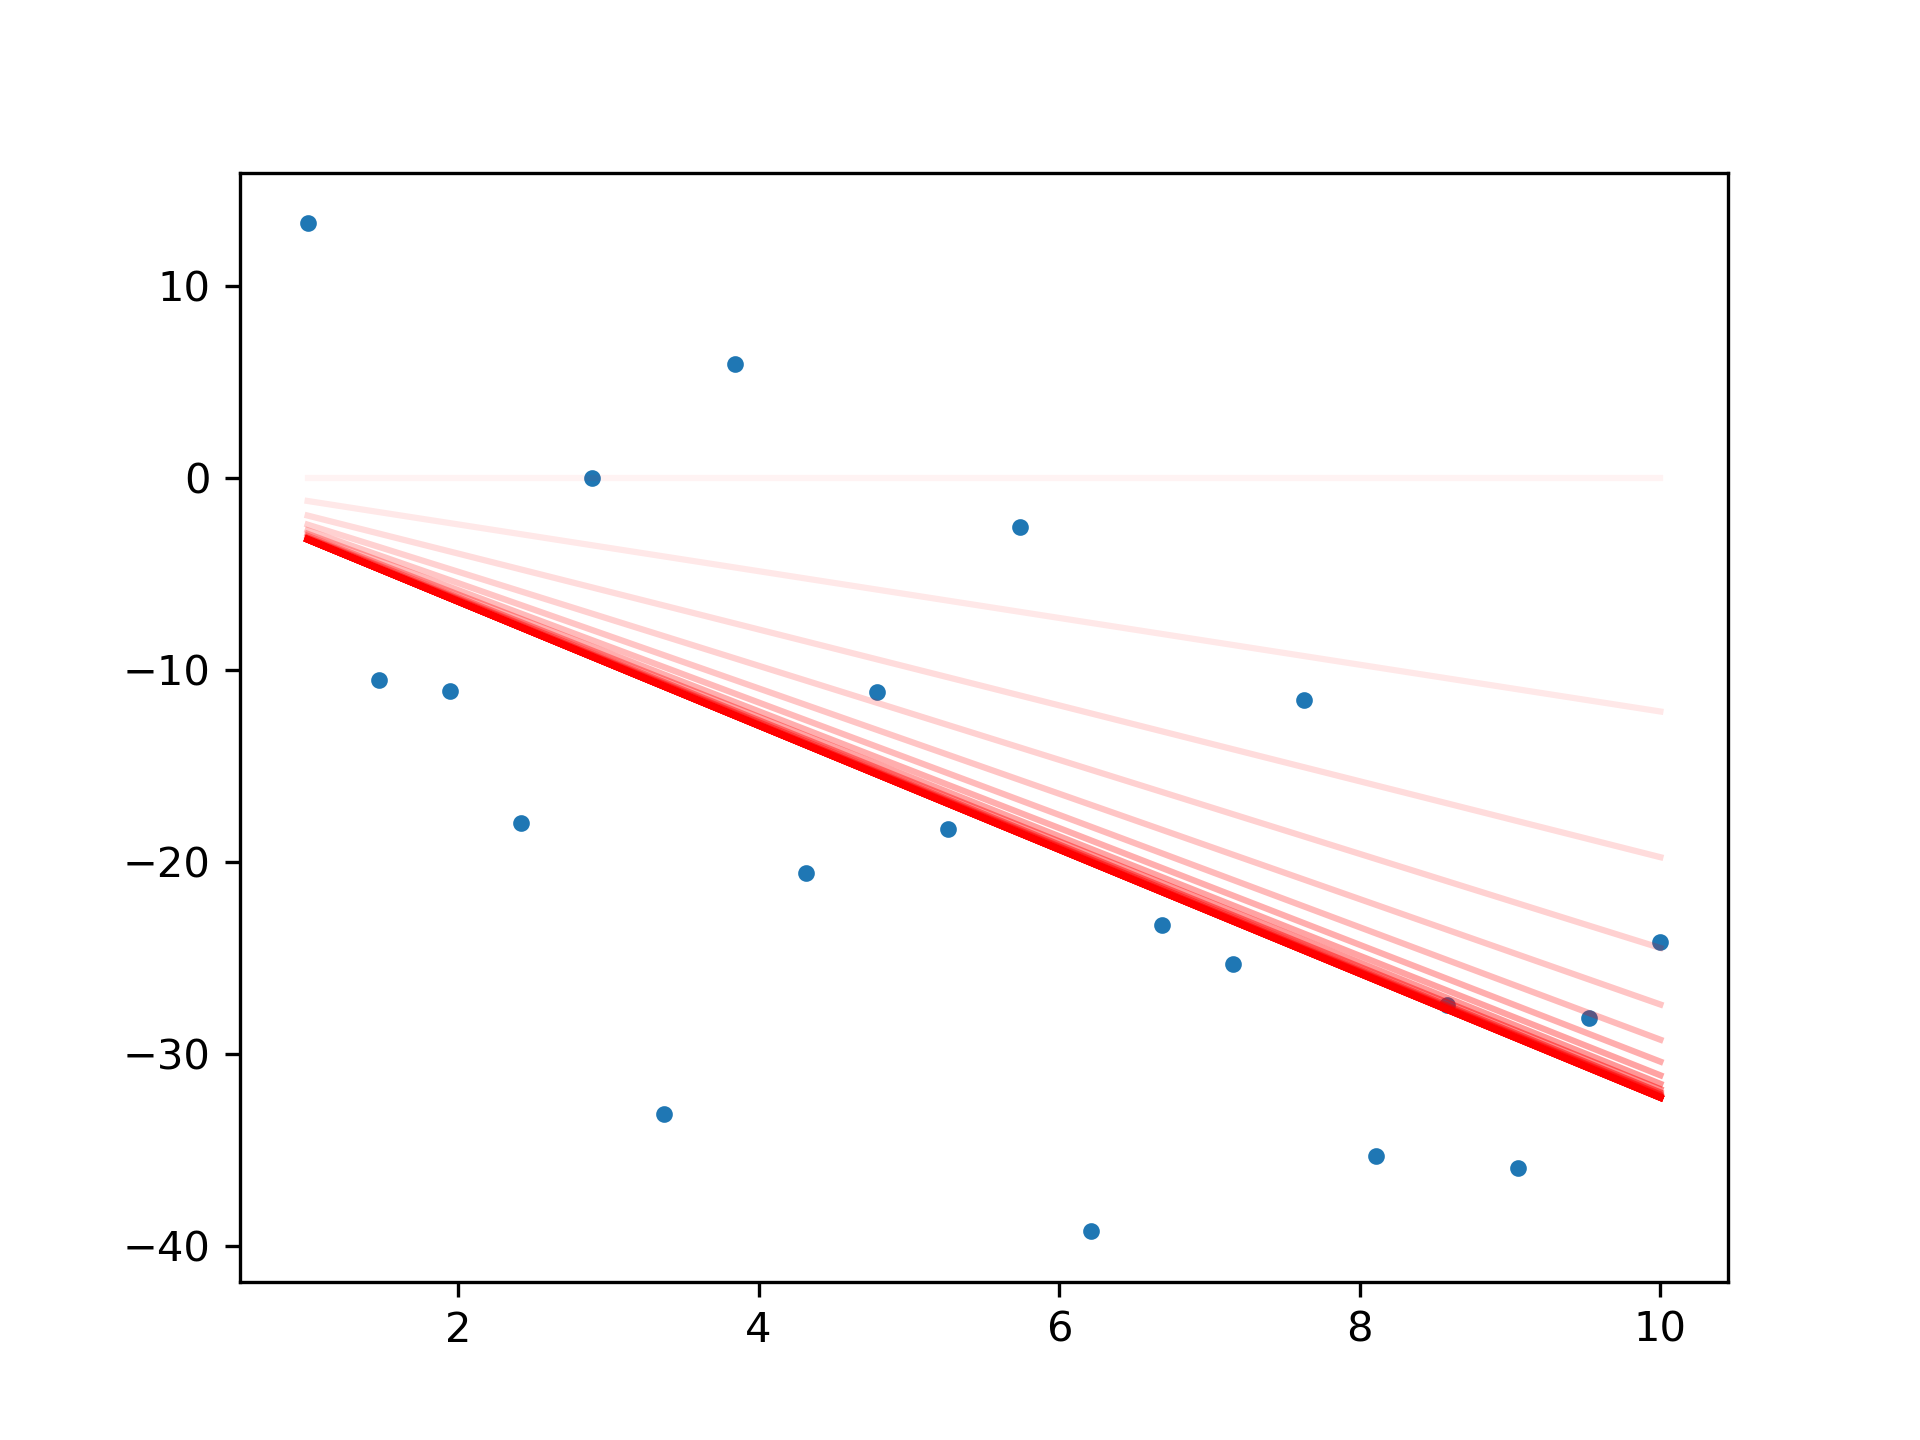

In [57]:
fig, ax = plt.subplots()
ax.plot(x, y, '.')
for t in range(w_hist.shape[0]):
    ax.plot(x, w_hist[t]*x, 'r-', alpha=(t+1)/(w_hist.shape[0]+.1))


In [56]:
len(w_hist)
print(w)

[-3.22903676]


Regularization
===========

<IPython.core.display.Javascript object>


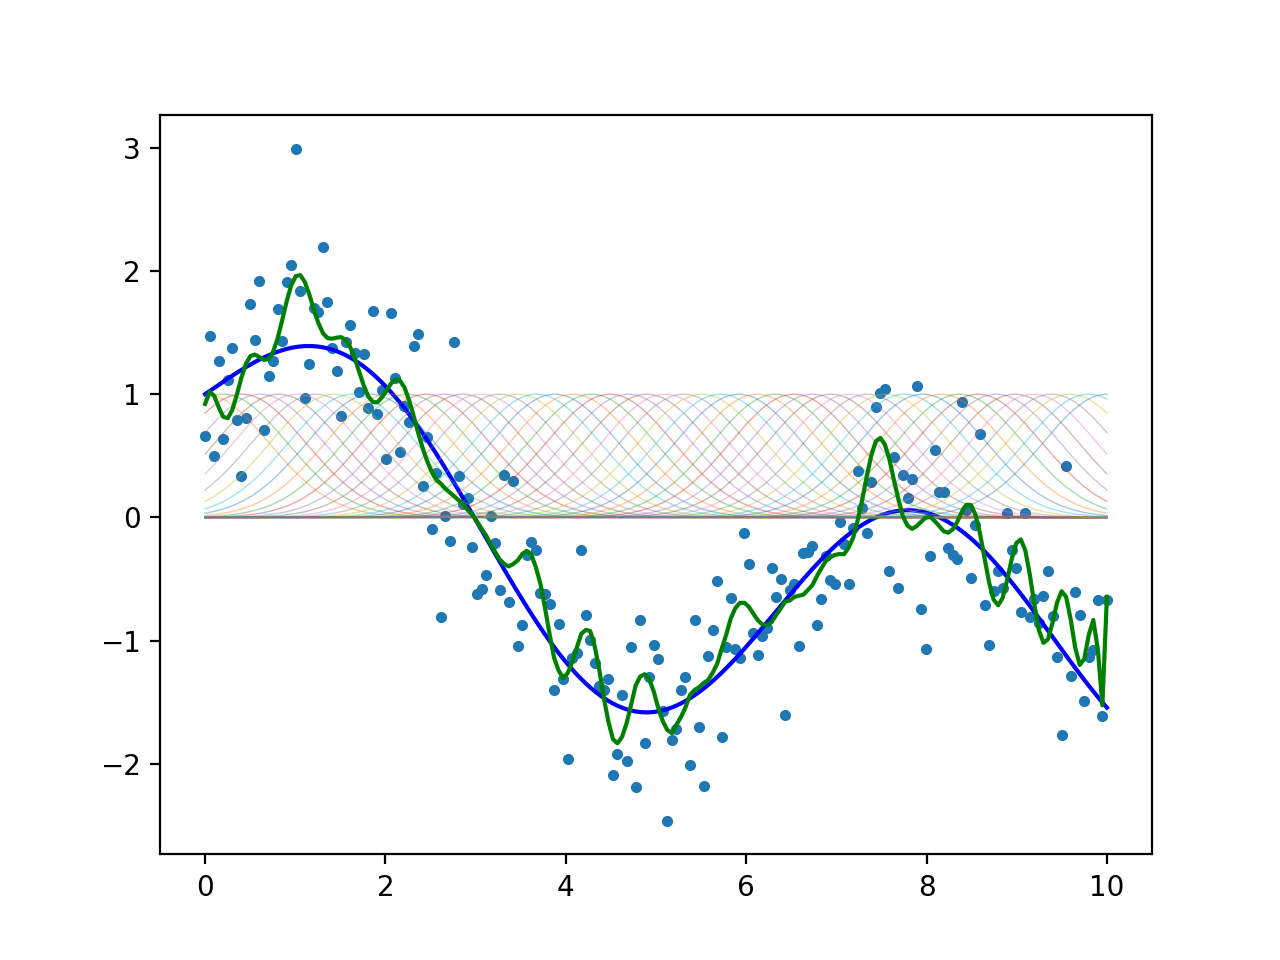

<ipython-input-51-eedf50f83d3e>:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(Phi, y)[0]


In [51]:
N = 200
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)
phi = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
phi2 = lambda x,mu,sigma: 1/(1 + np.exp(-(x - mu)))
mu = np.linspace(0,10,50)
Phi = phi(x[:,None], mu[None,:],1)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x,yt, 'b-')
w = np.linalg.lstsq(Phi, y)[0]
yh = np.dot(Phi,w)
for d in range(w.shape[0]):
    plt.plot(x, Phi[:,d], '-', alpha=.4, linewidth=.5 )
plt.plot(x, yh, 'g-')

<IPython.core.display.Javascript object>


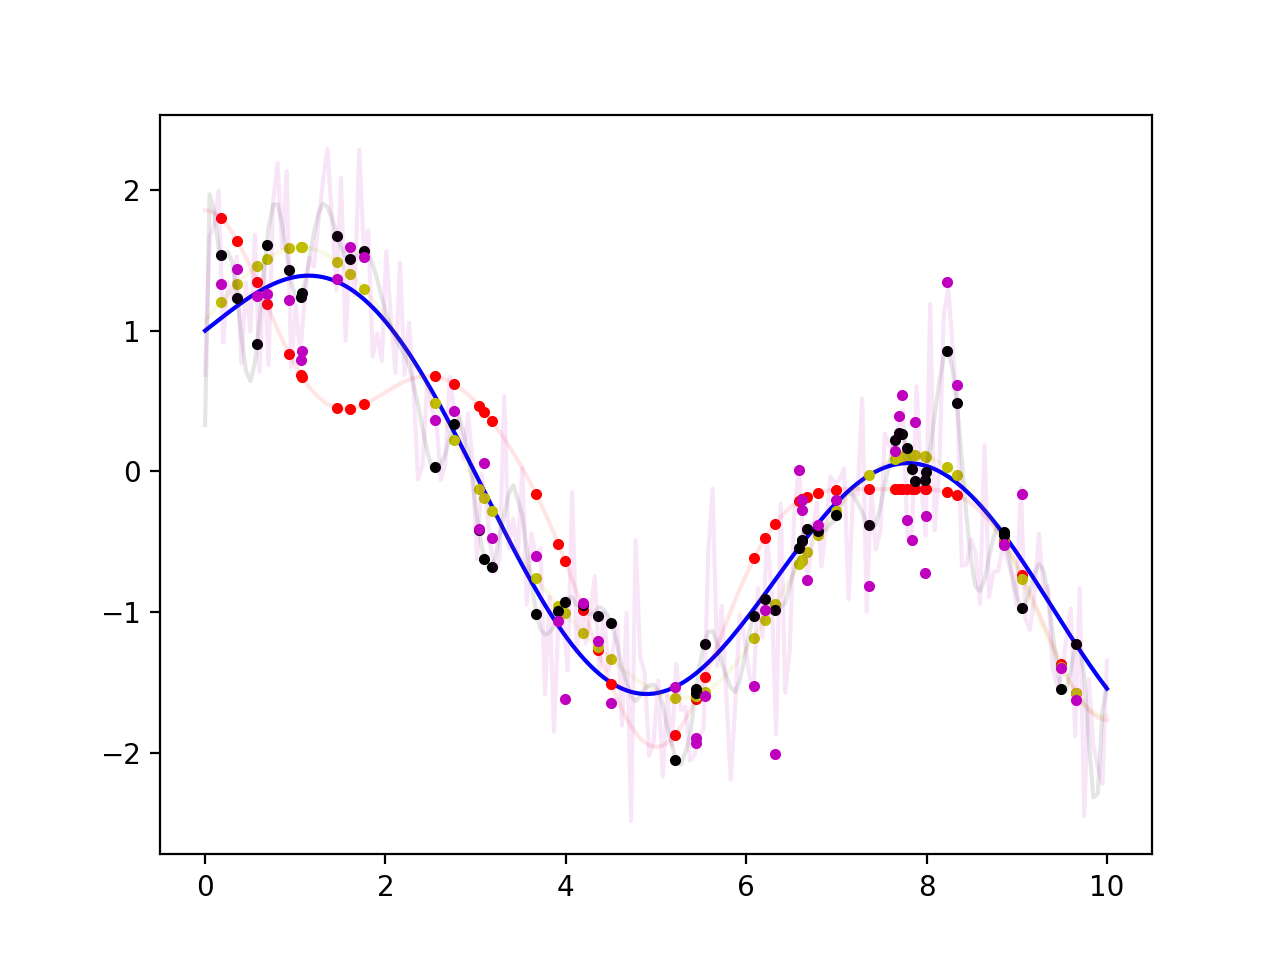

<ipython-input-24-27fae55166b5>:10: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(Phi, y)[0]


In [24]:
Nt = 50
x_test = np.random.rand(Nt)*10
y_test = np.sin(x_test) + np.cos(x_test**.5) + .5*np.random.randn(Nt)
fig, ax = plt.subplots()
plt.plot(x,yt, 'b-')
for D,s,c in [(5,1,'r'),(10,1,'y'),(50,1,'k'),(200,.1,'m')]:
    mu = np.linspace(0,10,D)
    Phi = phi(x[:,None], mu[None,:], s)
    Phi_t = phi(x_test[:,None], mu[None,:], s)
    w = np.linalg.lstsq(Phi, y)[0]
    yh_t = np.dot(Phi_t, w)
    yh = np.dot(Phi, w)
    plt.plot(x, yh, c+'-', alpha=.1)
    plt.plot(x_test, yh_t, c+'.')




<IPython.core.display.Javascript object>


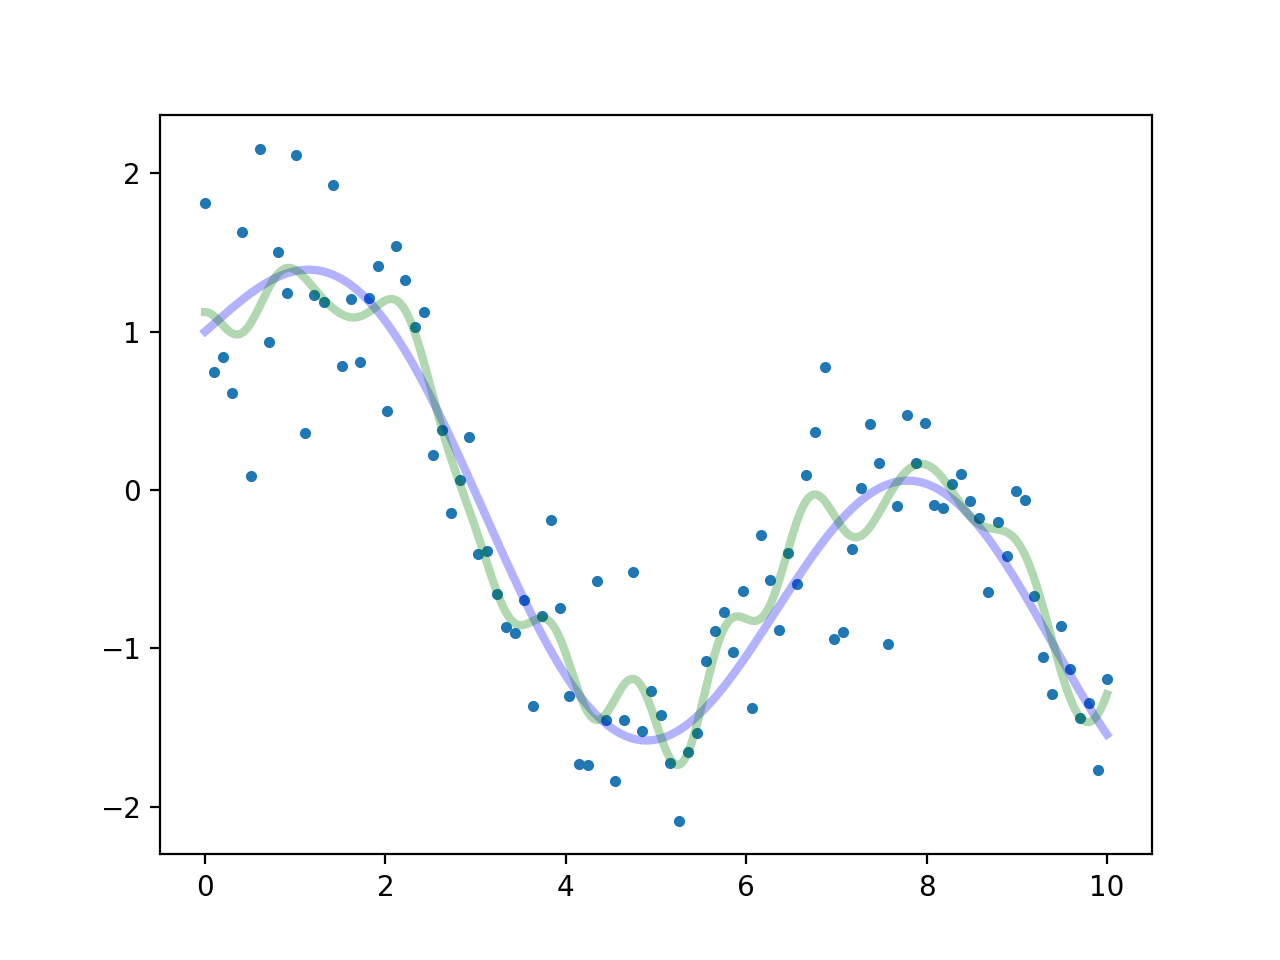

In [6]:
np.random.seed(1)
N =100
Nt=500
D = 100
sig = .5
x = np.linspace(0,10, N)
xt = np.linspace(0,10,Nt)
yt = np.sin(x) + np.cos(x**.5)
y_truth = np.sin(xt) + np.cos(xt**.5)
y = yt + .5*np.random.randn(N)
phi = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
phi3 = lambda x,mu: x**mu
mu = np.linspace(0,10,D)
Phi = phi(x[:,None], mu[None,:],sig)
fig, ax = plt.subplots()
plt.plot(x, y, '.', alpha=1)
plt.plot(xt,y_truth, 'b-', alpha=.3, linewidth=3)
reg = .1
#w = np.linalg.lstsq(Phi, y, rcond=1e-15)[0]
w = np.dot(np.dot( np.linalg.inv(np.dot(Phi.T,Phi) + reg*np.eye(D)), Phi.T) ,y)
yh = np.dot(Phi,w)
Phit = phi(xt[:,None], mu[None,:], sig)
y_test = np.dot(Phit,w)
# for d in range(w.shape[0]):
#     plt.plot(x, w[d]*Phi[:,d], '-.', alpha=1, linewidth=1 )
plt.plot(xt, y_test, 'g-', alpha=.3, linewidth=3)


In [98]:
y = np.random.randint(10, size=(100))
yhot = np.zeros(100, 10)
yhot[y] = 1

Gaussian Naive Bayes
========

(150, 2) (150,)


<IPython.core.display.Javascript object>


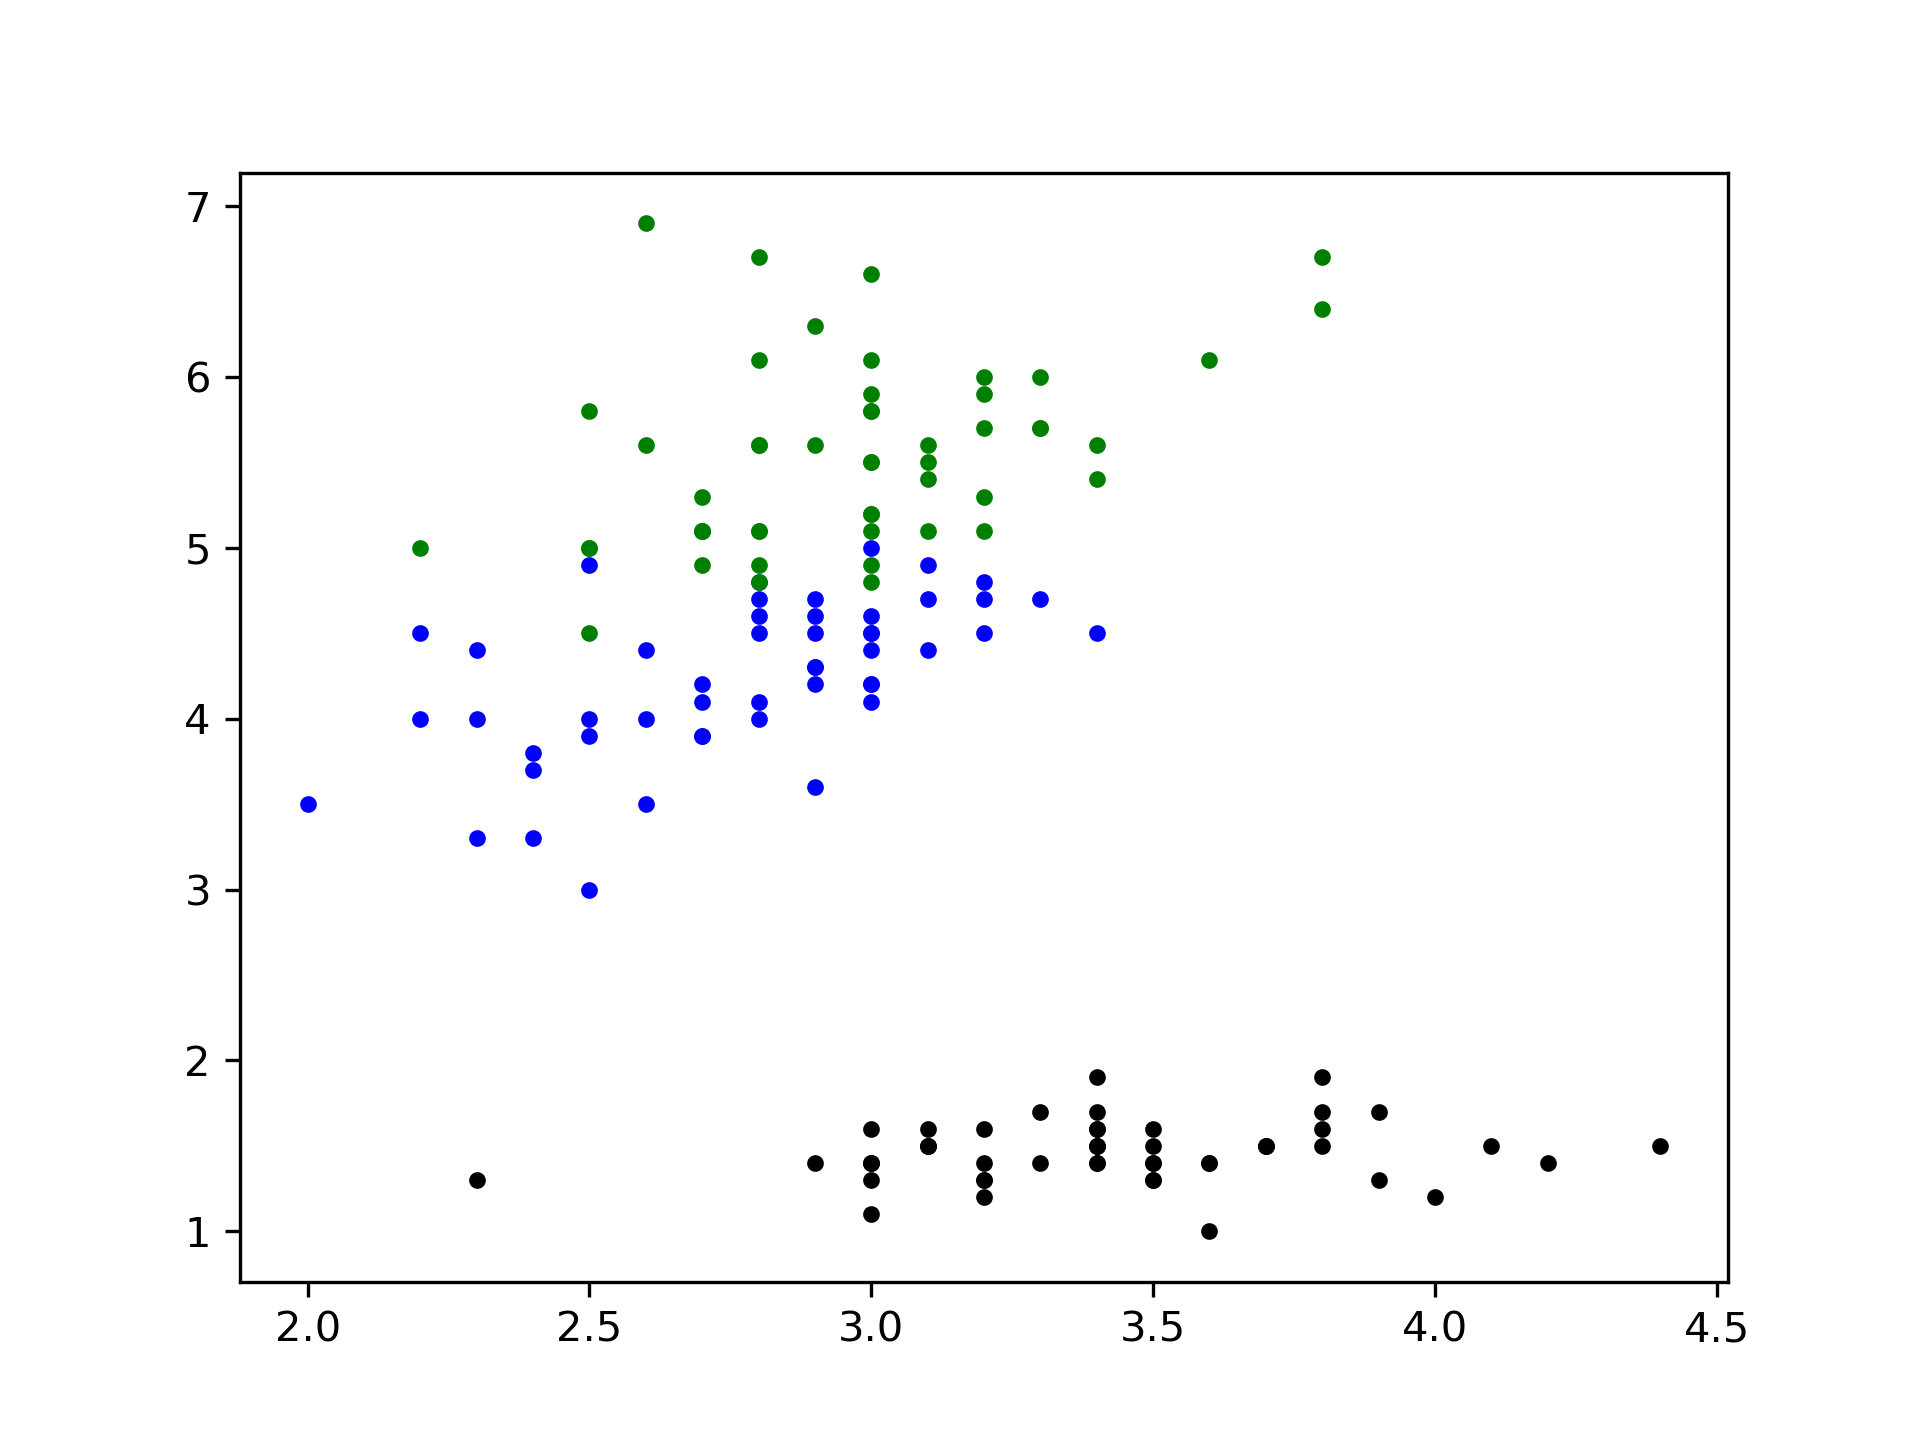

In [31]:

from sklearn import datasets
iris = datasets.load_iris()
Xd = iris["data"][:, (1,2)]  # petal width
yd = (iris["target"]).astype(np.int)  # 1 if Iris-Virginica, else 0
print(Xd.shape, yd.shape)
fig, ax = plt.subplots()
plt.plot(Xd[yd==0,0], Xd[yd==0,1], 'k.' )
plt.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
plt.plot(Xd[yd==2,0], Xd[yd==2,1], 'g.' )


<IPython.core.display.Javascript object>


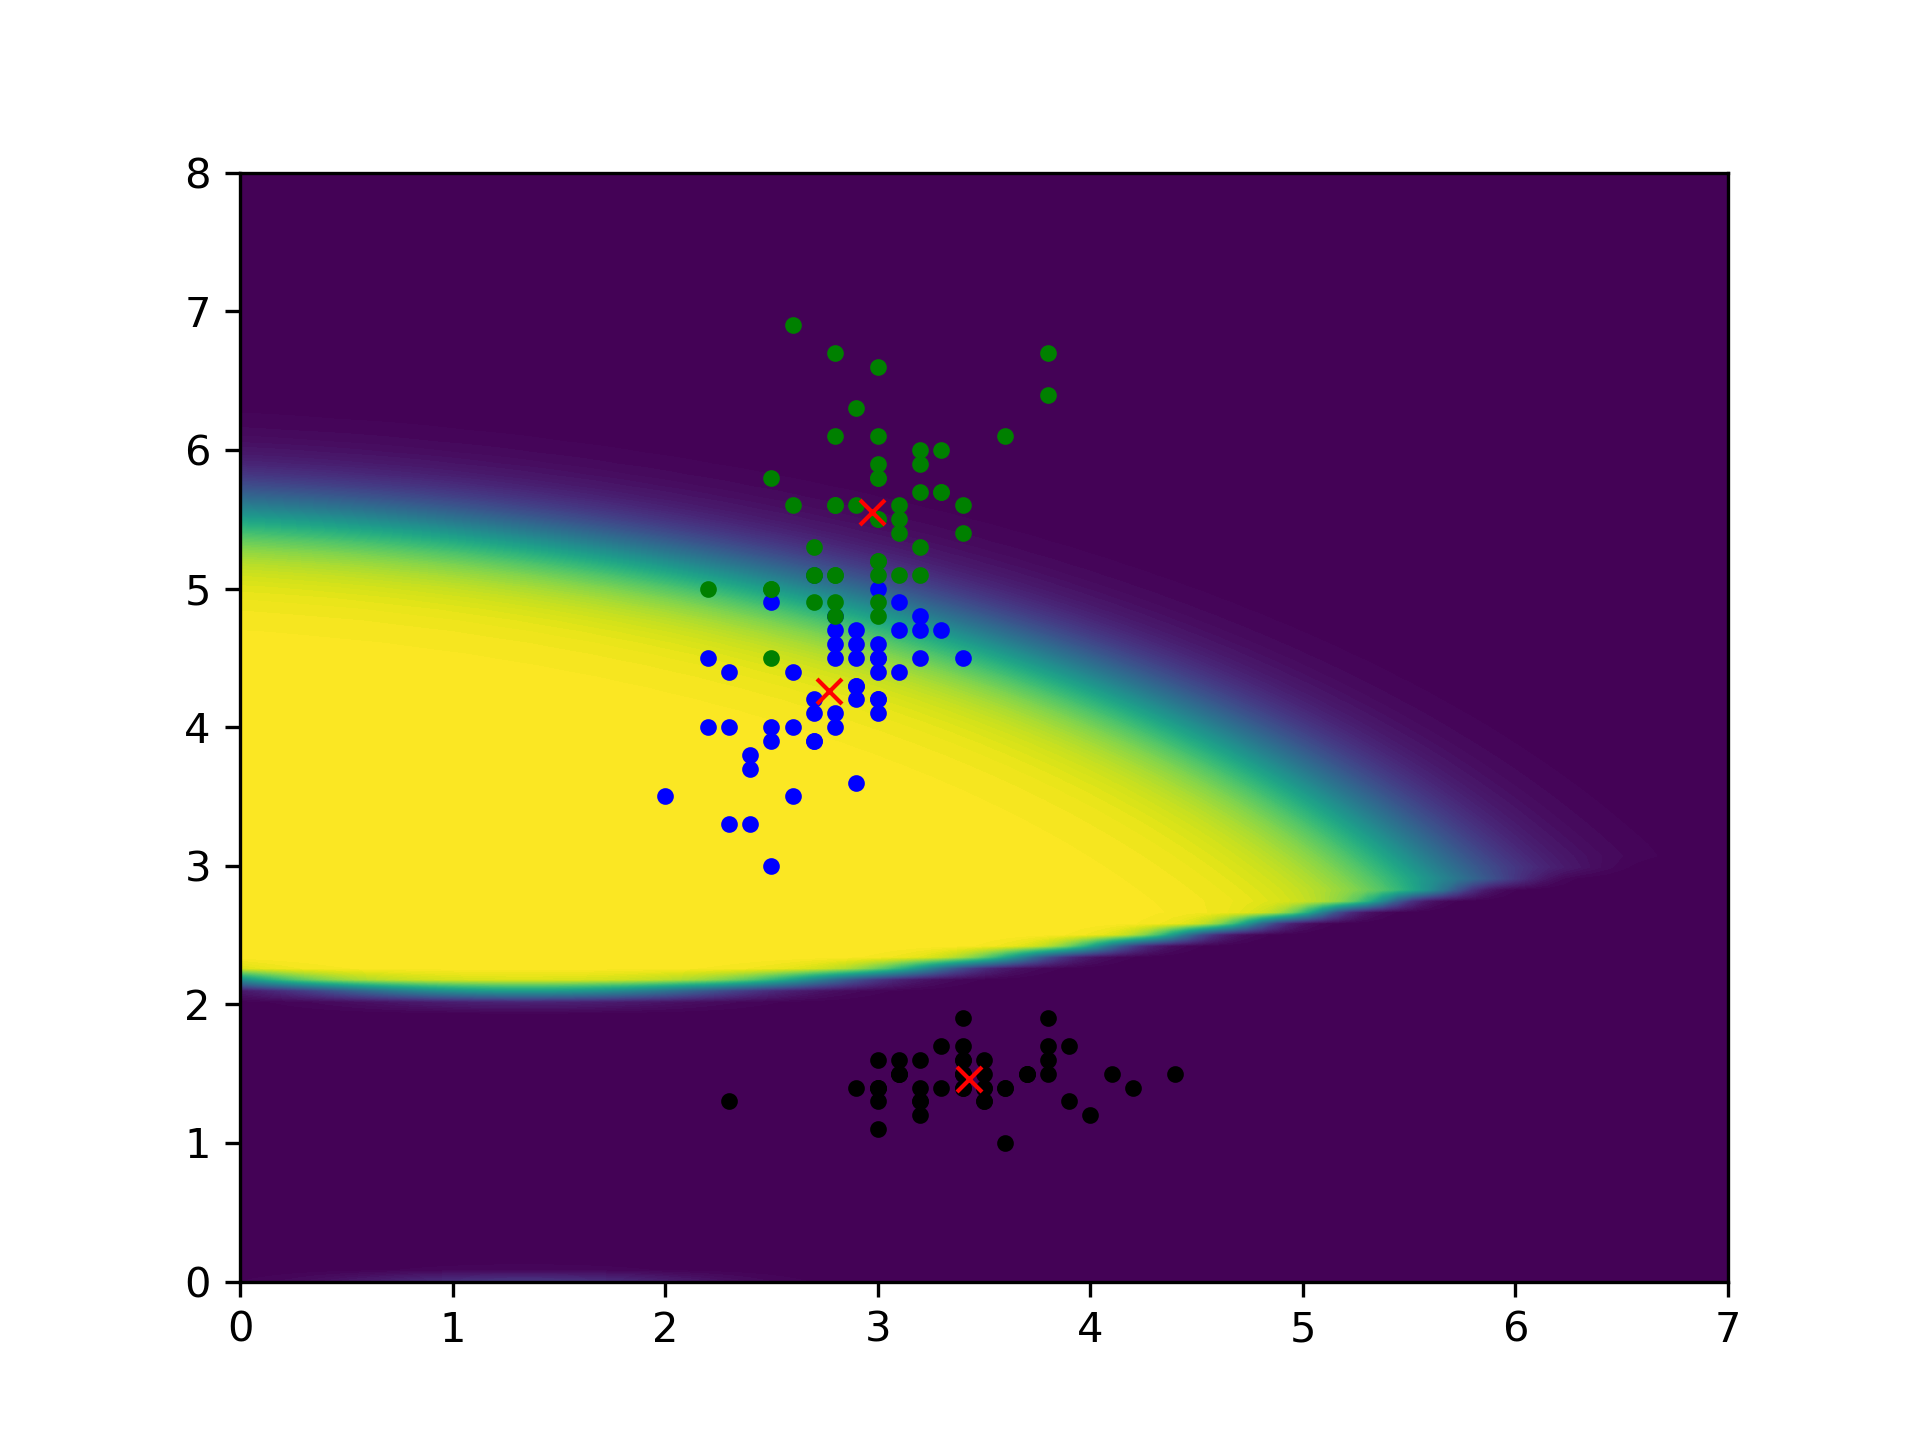

In [36]:
def plot_contour(f, xbound, ybound, contourf=True, ax=None):
    xrange = np.linspace(xbound[0], xbound[1], 100)
    yrange = np.linspace(ybound[0], ybound[1], 100)
    Xg, Yg = np.meshgrid(xrange, yrange)
    Xinput = np.vstack([Xg.ravel(), Yg.ravel()]).T
    Zg = np.reshape(f(Xinput), (100,100)) #np.zeros_like(Xg)
    #for i,j in itertools.product(range(100), range(100)):
    #    Zg[i,j] = f(np.array([Xg[i,j], Yg[i,j]]))
    if not ax:
        fig, ax = plt.subplots()
        ax.autoscale(False) #
    if contourf:
        extent=[xbound[0], xbound[1], ybound[0], ybound[1]]
        ax.contourf(Zg, 100, extent=extent)
        ax.autoscale(False) #
        #extent=[xbound[0], xbound[1], ybound[0], ybound[1]]
        #ax.imshow(np.rot90(Zg), extent=extent)
    else:
        ax.contour(Xg, Yg, Zg, 100)
    return ax

def logsumexp(
  Z# C x N 
):
    Zmax = np.max(Z,0)[None,:]
    lse = Zmax + np.log(np.sum(np.exp(Z - Zmax)))
    return lse

def GaussianNaiveBayes(
                X, # N x D
                y, # N x C
                Xt,# Nt x D
               ):
    N,C = y.shape
    D = X.shape[1]
    mu, s = np.zeros((C,D)), np.zeros((C,D))
    for c in range(C):
        inds = np.nonzero(y[:,c])[0]
        mu[c,:] = np.mean(X[inds,:], 0)
        s[c,:] = np.std(X[inds,:], 0)
    #print(mu,s)
    log_prior = np.log(np.mean(y, 0))[:,None]
    log_likelihood = - np.sum( .5*np.log(2*np.pi) + np.log(s[:,None,:]) 
        +.5*(((Xt[None,:,:] - mu[:,None,:])/s[:,None,:])**2), 2)
    #log_likelihood = - np.sum (np.log(np.sqrt(2*np.pi)*(s[:,None,:]**2)) +\
    #    ((Xt[None,:,:] - mu[:,None,:])**2)/(2*(s[:,None,:]**2)), 2)
    log_post = log_prior*0 + log_likelihood
    log_post -= logsumexp(log_post)
    post = np.exp(log_post)
    post /= np.sum(post,0)
    labels = np.argmax(post,0)
    #print(log_post)
    return post, (mu,s)


yhot = np.zeros((yd.shape[0],3))
yhot[:,0], yhot[:,1], yhot[:,2] = (yd == 0), (yd == 1), (yd == 2)

lp0 = lambda inp: GaussianNaiveBayes(Xd, yhot, inp)[0][0,:]
lp1 = lambda inp: GaussianNaiveBayes(Xd, yhot, inp)[0][1,:]
#lp2 = lambda inp: GaussianNaiveBayes(Xd, yhot, inp)[0][2,:]
yh = lambda inp: GaussianNaiveBayes(Xd, yhot, inp)[0]

mus = GaussianNaiveBayes(Xd, yhot, Xd)[1][0]

# def lp(inp):
#     yh = GaussianNaiveBayes(Xd, yhot, inp)[0]
#     return (yh[0,:])
fig, ax = plt.subplots()
b1, b2 = [0,7], [0,8]
ax.set_xlim(b1)                                                                           
ax.set_ylim(b2)                                                                           
ax.autoscale(False) #
#ax = plot_contour(lp0, b1, b2, ax=ax)
ax = plot_contour(lp1, b1, b2, ax=ax)
#ax = plot_contour(lp2, b1, b2, ax=ax)
#ax = plot_contour(yh, b1, b2, ax=ax)
ax.plot(Xd[yd==0,0], Xd[yd==0,1], 'k.' )
ax.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
ax.plot(Xd[yd==2,0], Xd[yd==2,1], 'g.' )
ax.plot(mus[:, 0], mus[:,1], 'xr')



In [40]:
np.log(5e-200)

-458.907580686375

Perceptron 
==========

In [162]:
    
def Perceptron(X,y,max_iters=1000):
    N,D = X.shape
    w = np.random.rand(D) 
    w_hist = [w]
    n_hist = []
    y = np.sign(y -.1)
    t = 0
    change = True
    while change and t < max_iters:
        change = False
        for _ in range(N):
            n = np.random.randint(N)
            z = np.dot(X[n,:], w)
            yh = np.sign(z)
            if yh == y[n]:
                continue
            w_new = w + (y[n]-yh)*X[n,:]
            w = w_new
            w_hist.append(w)
            n_hist.append(n)
            change = True
            t += 1
            if t >= max_iters:
                break

        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    n_hist = np.vstack(n_hist)
    return w, w_hist, n_hist


<IPython.core.display.Javascript object>


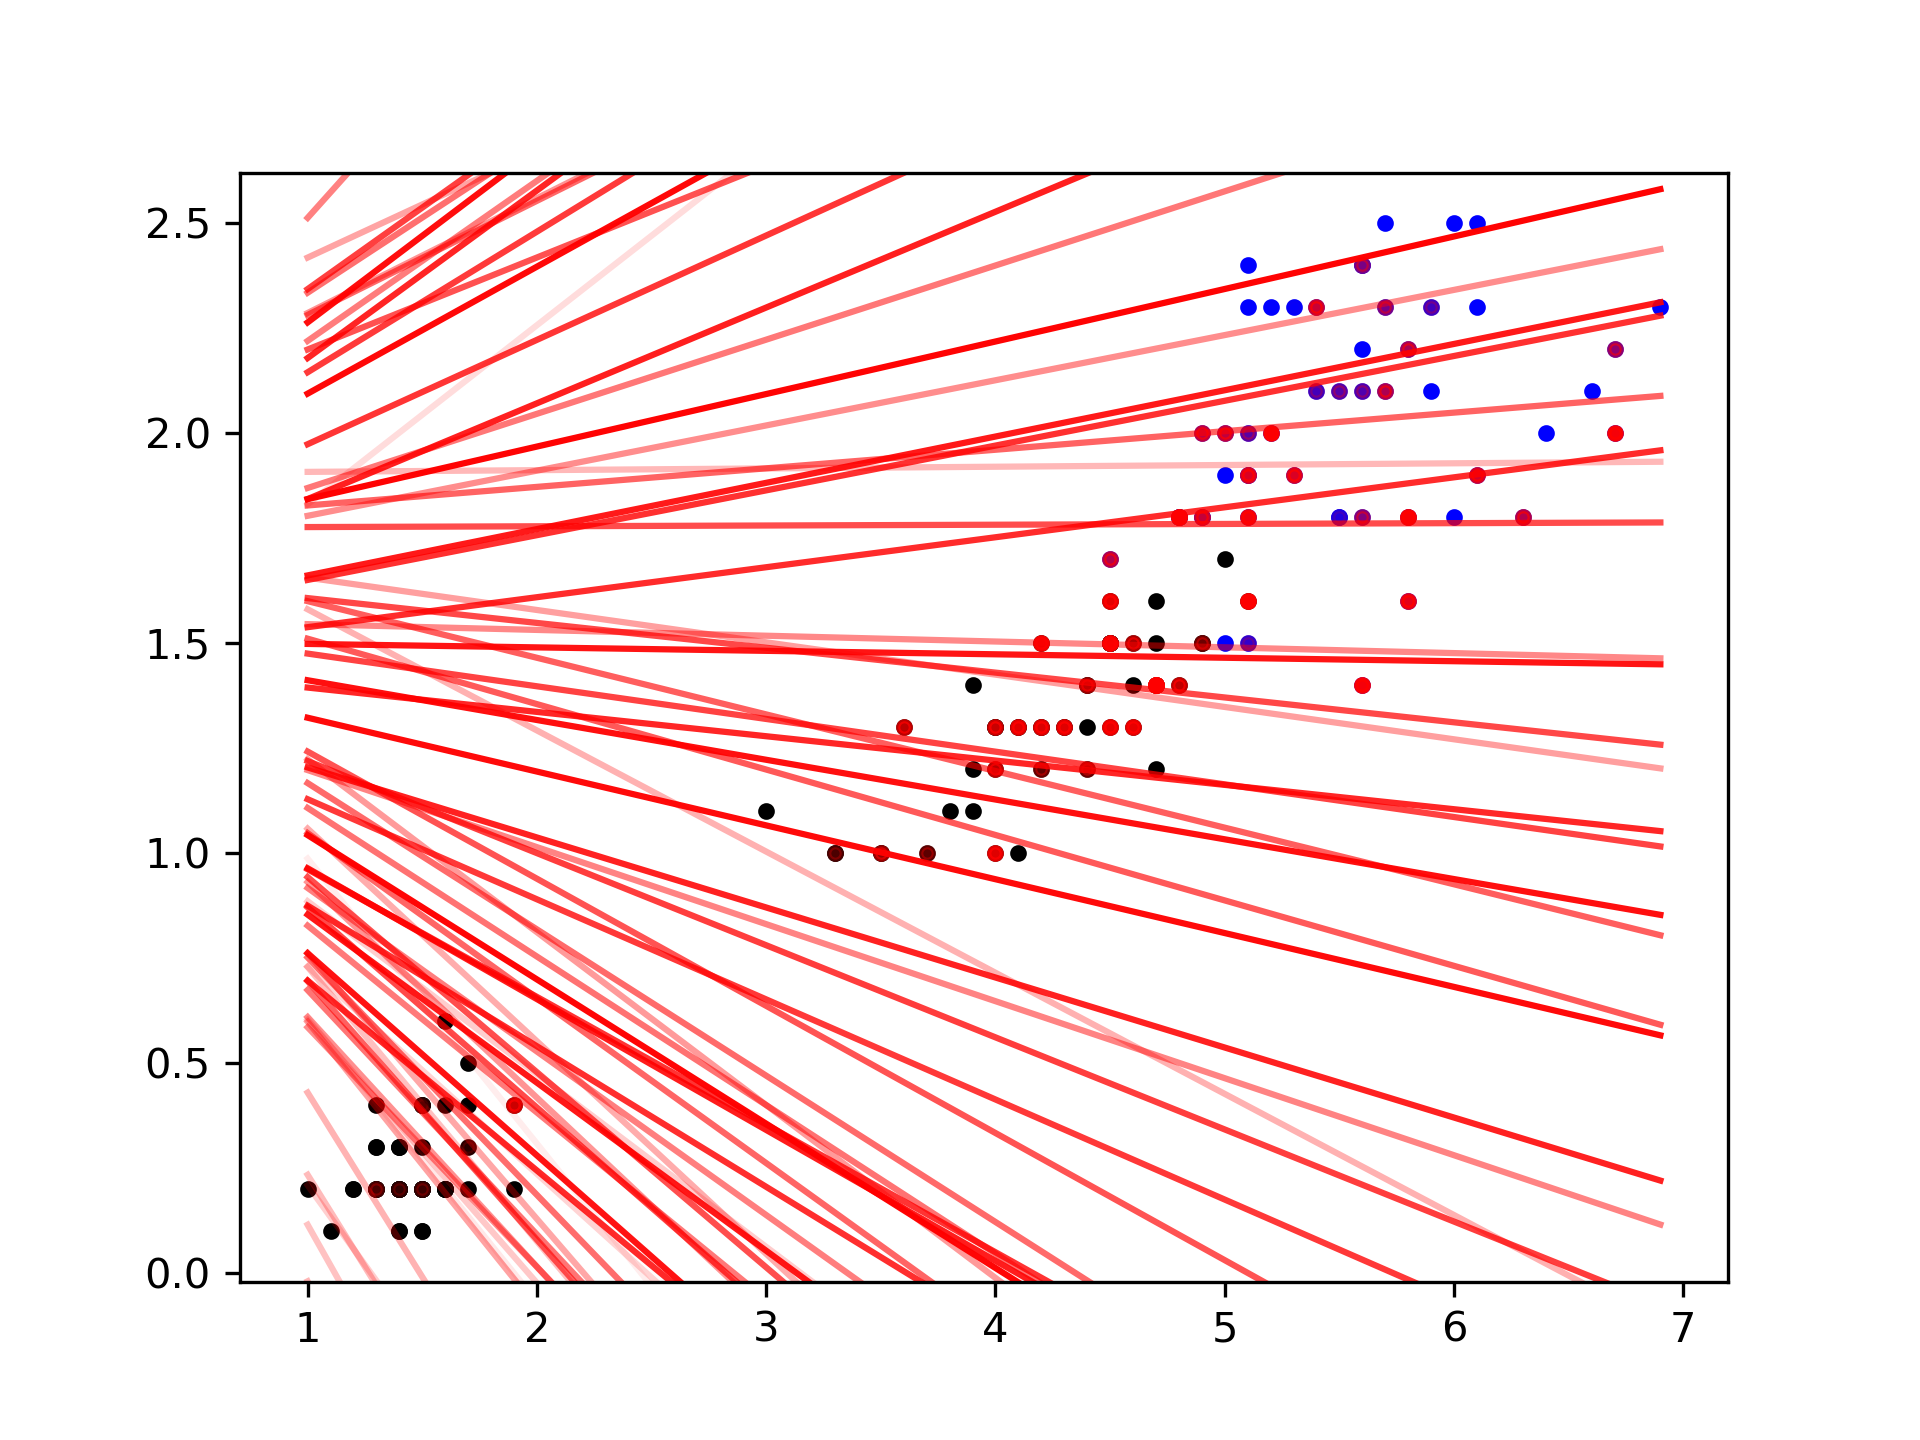

In [165]:
# separable (2,3) target 0
np.random.seed(10)
w, w_hist, n_hist = Perceptron(Xd, yd, 100)
fig, ax = plt.subplots()
ax.plot(Xd[yd==0,0], Xd[yd==0,1], 'k.' )
ax.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
ax.autoscale(False) #

x = np.linspace(np.min(Xd[:,0]), np.max(Xd[:,0]), 100)
for t in range(w_hist.shape[0]-1):
    wt = w_hist[t]
    coef = -wt[0]/wt[1]
    ax.plot(x, coef*x - wt[2]/wt[1], 'r-', alpha=(t+1)/(w_hist.shape[0]+.1))
    #if t > 0:
    ax.plot(Xd[n_hist[t], 0], Xd[n_hist[t], 1], 'r.', alpha=(t+1)/(w_hist.shape[0]+.1))
    t += 1
plt.show()

Hinge Loss
=============

In [287]:
def hinge_cost(X,y,w, lamb2=0, lamb1=0):
    yh = np.dot(X, w)
    J = np.mean(np.maximum(0, 1 - y*yh)) \
        + lamb2 * np.dot(w[:-1],w[:-1])/2 + lamb1 * np.sum(np.abs(w[:-1]))
    #J = ce(y,yh)
    return J

def subgradient(X, y, w, lamb2=0, lamb1=0):
    N,D = X.shape
    yh = np.dot(X, w)
    violations = np.nonzero(yh*y < 1)[0]
    grad = -np.dot(X[violations,:].T, y[violations])/N
    grad[:-1] += lamb2 * w[:-1] + lamb1 * np.sign(w[:-1])
    return grad
    
def SubGD(X,y,lr=.1,eps=1e-18, max_iters=100000, lamb2=0, lamb1=0):
    
    N,D = X.shape
    w = np.zeros(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        g = subgradient(X, y, w, lamb1=lamb1, lamb2=lamb2)
        w = w - lr*g
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist

def SubSGD(X,y,lr=.01,eps=1e-18, max_iters=8000, lamb2=0, lamb1=0):
    
    N,D = X.shape
    w = np.ones(D)
    w_hist = [w]
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(1))
        g = subgradient(X[i,:], y[i], w, lamb1=lamb1, lamb2=lamb2)
        #lr = 1./(1+(t**.5))
        w = w - lr*g
        w_hist.append(w)
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w[t])))
    w_hist = np.vstack(w_hist)
    return w, w_hist


In [288]:
l1,l2 = 0, 1e-8
yd = np.sign(yd -.1)
w, w_hist = SubGD(Xd, yd, lamb1=l1, lamb2=l2)


<IPython.core.display.Javascript object>


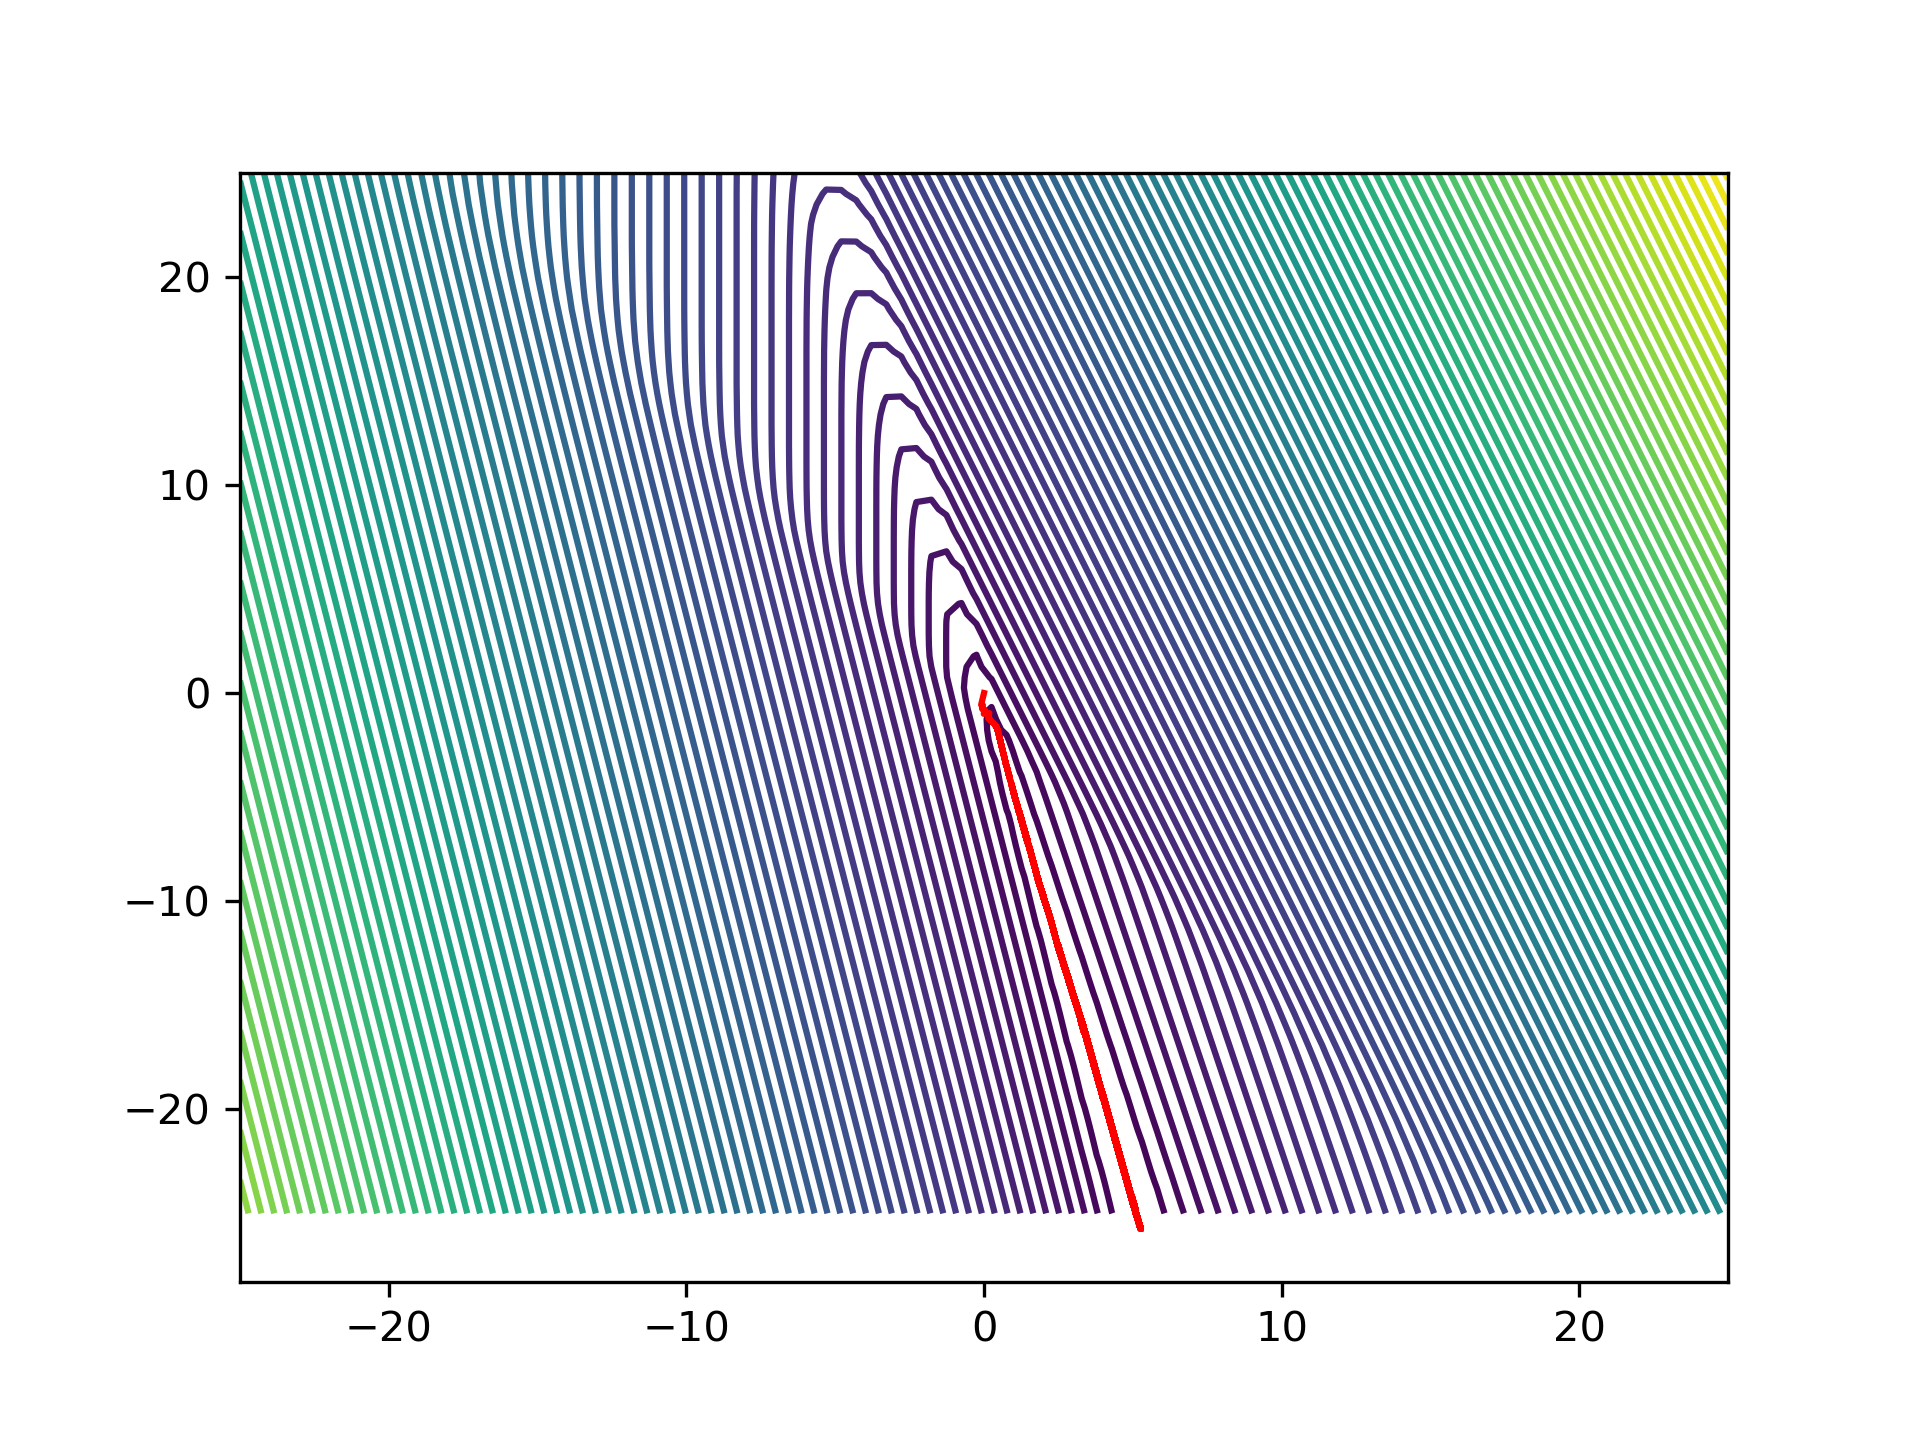

In [285]:
def plot_contour(f, xbound, ybound, contourf=False):
    xrange = np.linspace(xbound[0], xbound[1], 100)
    yrange = np.linspace(ybound[0], ybound[1], 100)
    Xg, Yg = np.meshgrid(xrange, yrange)
    Zg = np.zeros_like(Xg)
    for i,j in itertools.product(range(100), range(100)):
        Zg[i,j] = f(np.array([Xg[i,j], Yg[i,j]]))
    fig, ax = plt.subplots()
    if contourf:
        ax.contourf(Xg, Yg, Zg, 100)
    else:
        ax.contour(Xg, Yg, Zg, 100)
    return fig, ax

f = lambda alpha: hinge_cost(Xd,yd,alpha, lamb1=l1, lamb2=l2)
bmin, bmax = .9*np.min(w_hist, axis=1), 1.1*np.max(w_hist,axis=1)
fig, ax = plot_contour(f, [-25,25], [-25,25])#[bmin[0],bmax[0]], [bmin[1], bmax[1]])
#ax.plot(w_hist[-1,0]*0, w_hist[-1,1], 'rx',linewidth=.5)
ax.plot(w_hist[:,0], w_hist[:,1], 'r-')

plt.show()

<IPython.core.display.Javascript object>


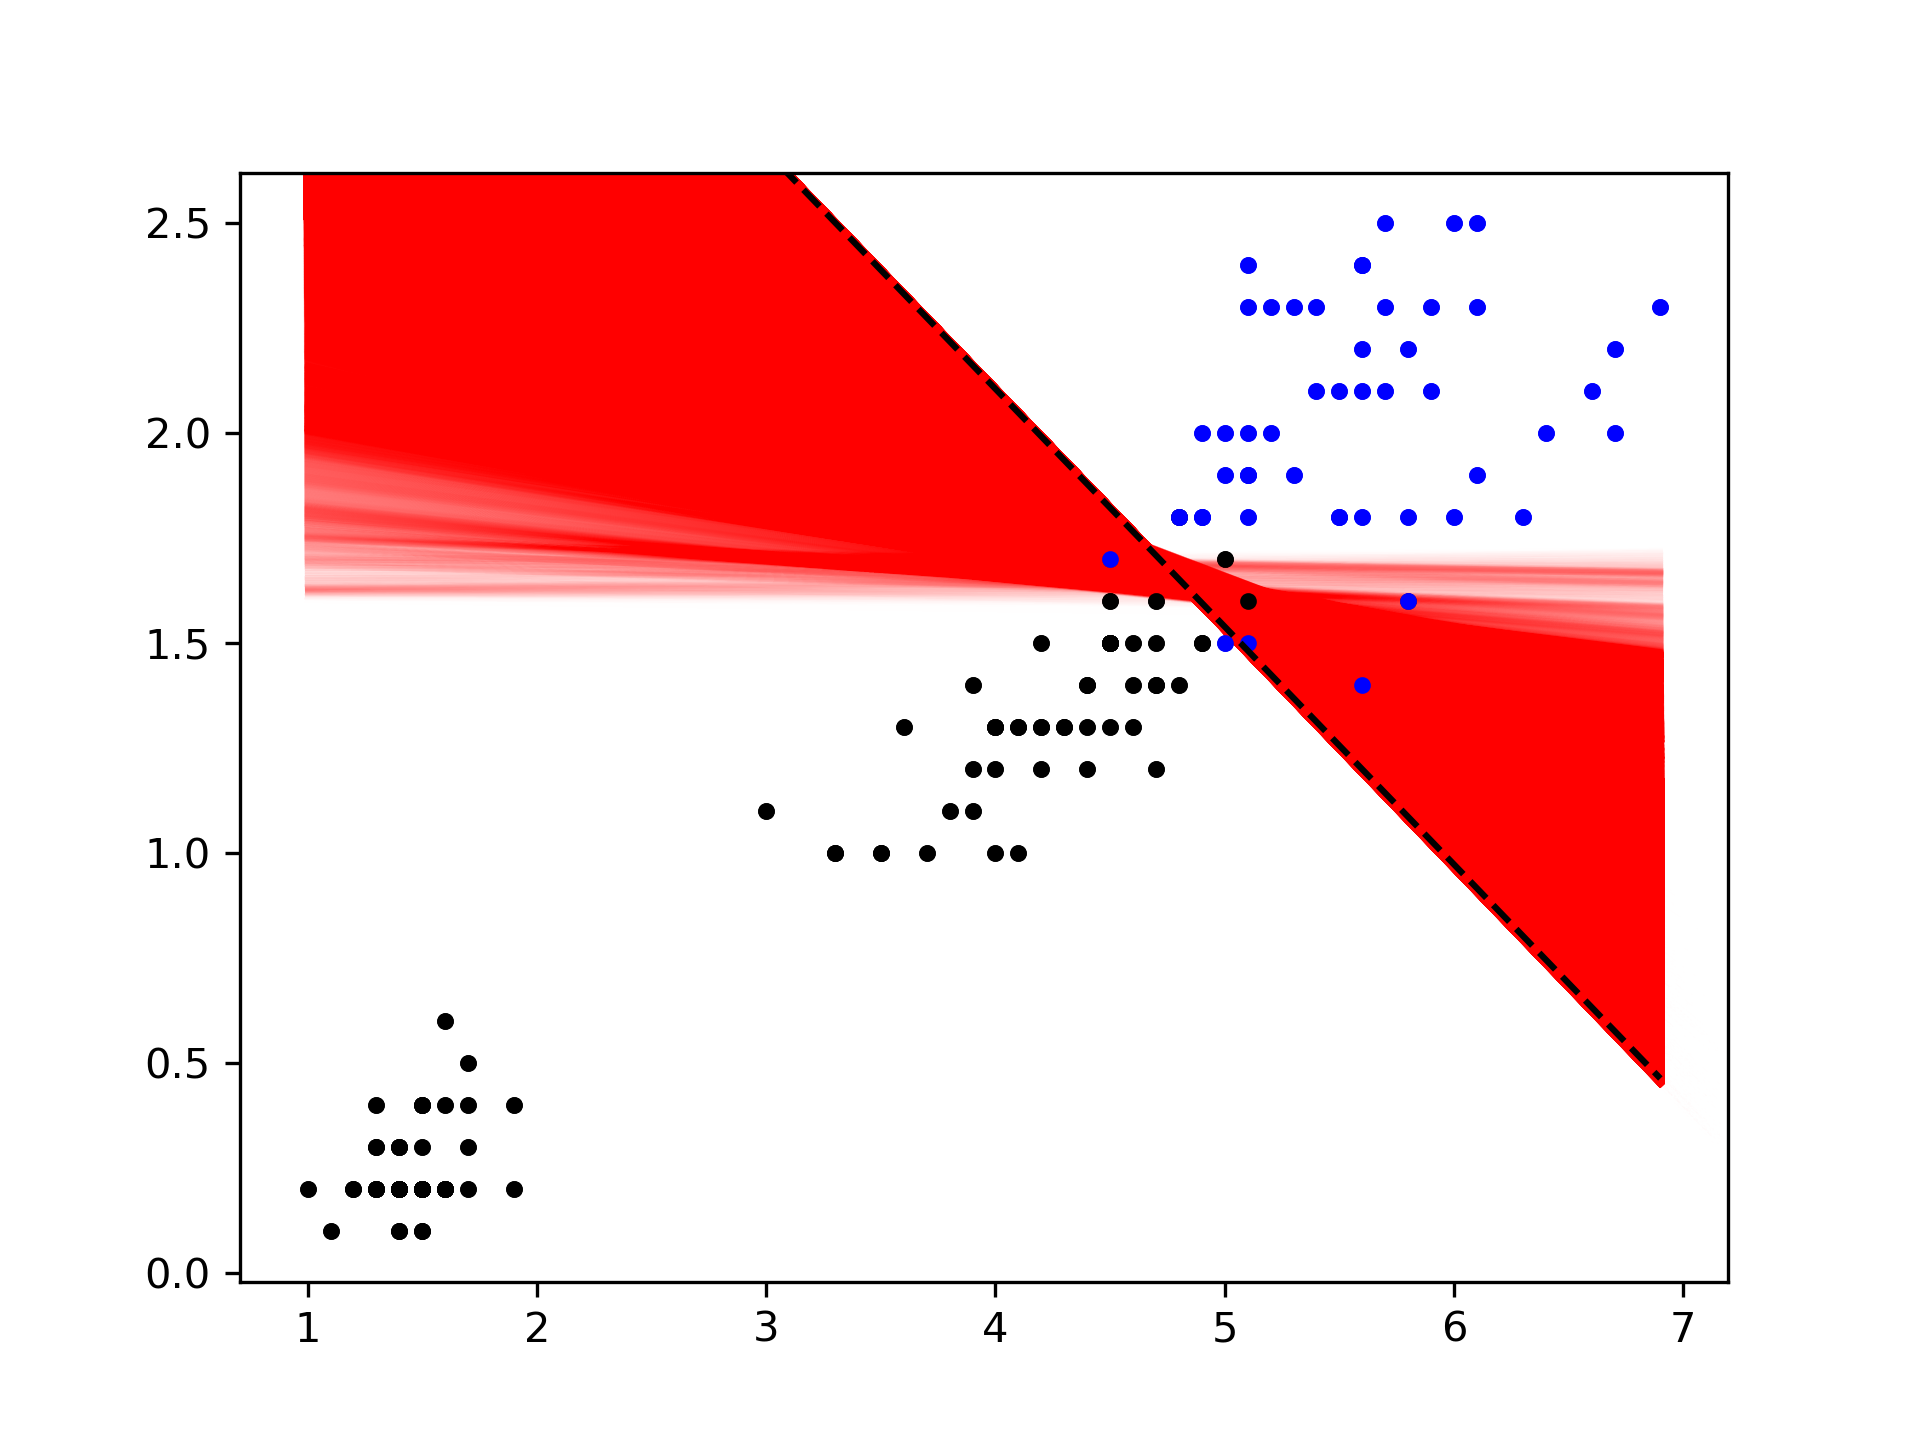

<ipython-input-289-ddc0ec3ca6a9>:11: RuntimeWarning: invalid value encountered in double_scalars
  coef = -wt[0]/wt[1]
<ipython-input-289-ddc0ec3ca6a9>:12: RuntimeWarning: invalid value encountered in double_scalars
  ax.plot(x, coef*x - wt[2]/wt[1], 'r-', alpha=(t+1)/(w_hist.shape[0]+.1))


In [289]:
# separable (2,3) target 0
np.random.seed(10)
fig, ax = plt.subplots()
ax.plot(Xd[yd==-1,0], Xd[yd==-1,1], 'k.' )
ax.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
ax.autoscale(False) #

x = np.linspace(np.min(Xd[:,0]), np.max(Xd[:,0]), 100)
for t in range(w_hist.shape[0]-1):
    wt = w_hist[t]
    coef = -wt[0]/wt[1]
    ax.plot(x, coef*x - wt[2]/wt[1], 'r-', alpha=(t+1)/(w_hist.shape[0]+.1))
    #if t > 0:
    t += 1
ax.plot(Xd[yd==-1,0], Xd[yd==-1,1], 'k.' )
ax.plot(Xd[yd==1,0], Xd[yd==1,1], 'b.' )
    

ax.plot(x, coef*x - w[2]/w[1], 'k--')
plt.show()

Bootstrap
==========

<IPython.core.display.Javascript object>


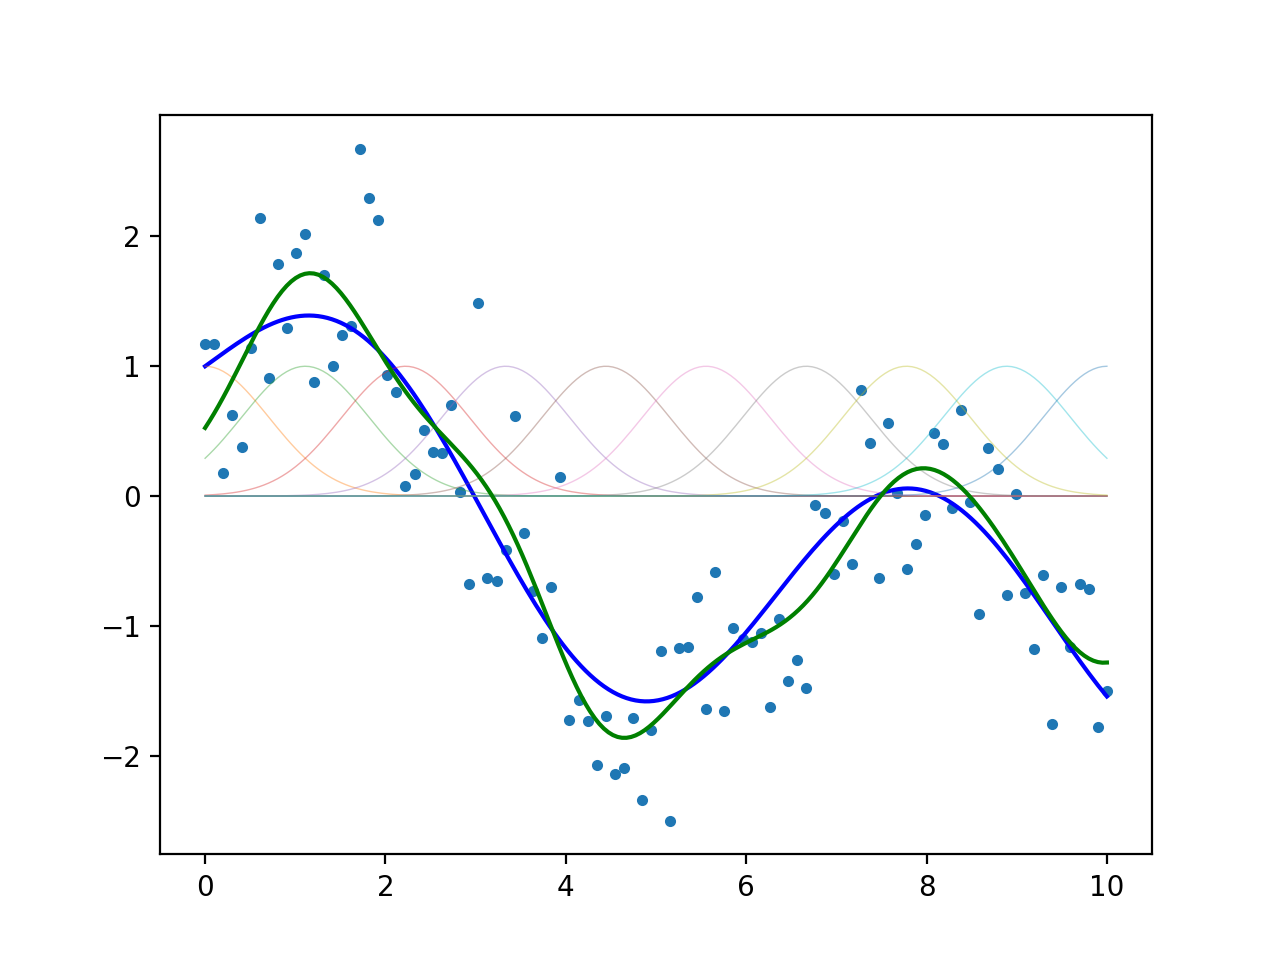

<ipython-input-10-3e7417f2e5ce>:17: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w = np.linalg.lstsq(Phi, y)[0]


In [10]:
N = 100
Nt = 200
D=10
x_test = np.linspace(0,10, Nt)
y_test = np.sin(x_test) + np.cos(x_test**.5)
x = np.linspace(0,10, N)
yt = np.sin(x) + np.cos(x**.5)
y = yt + .5*np.random.randn(N)
phi = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
phi2 = lambda x,mu,sigma: 1/(1 + np.exp(-(x - mu)))
mu = np.linspace(0,10,D)
Phi = phi(x[:,None], mu[None,:],1)
Phit = phi(x_test[:,None], mu[None,:],1)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
w = np.linalg.lstsq(Phi, y)[0]
yht = np.dot(Phit,w)
for d in range(w.shape[0]):
    plt.plot(x_test, Phit[:,d], '-', alpha=.4, linewidth=.5 )
plt.plot(x_test, yht, 'g-')

<IPython.core.display.Javascript object>


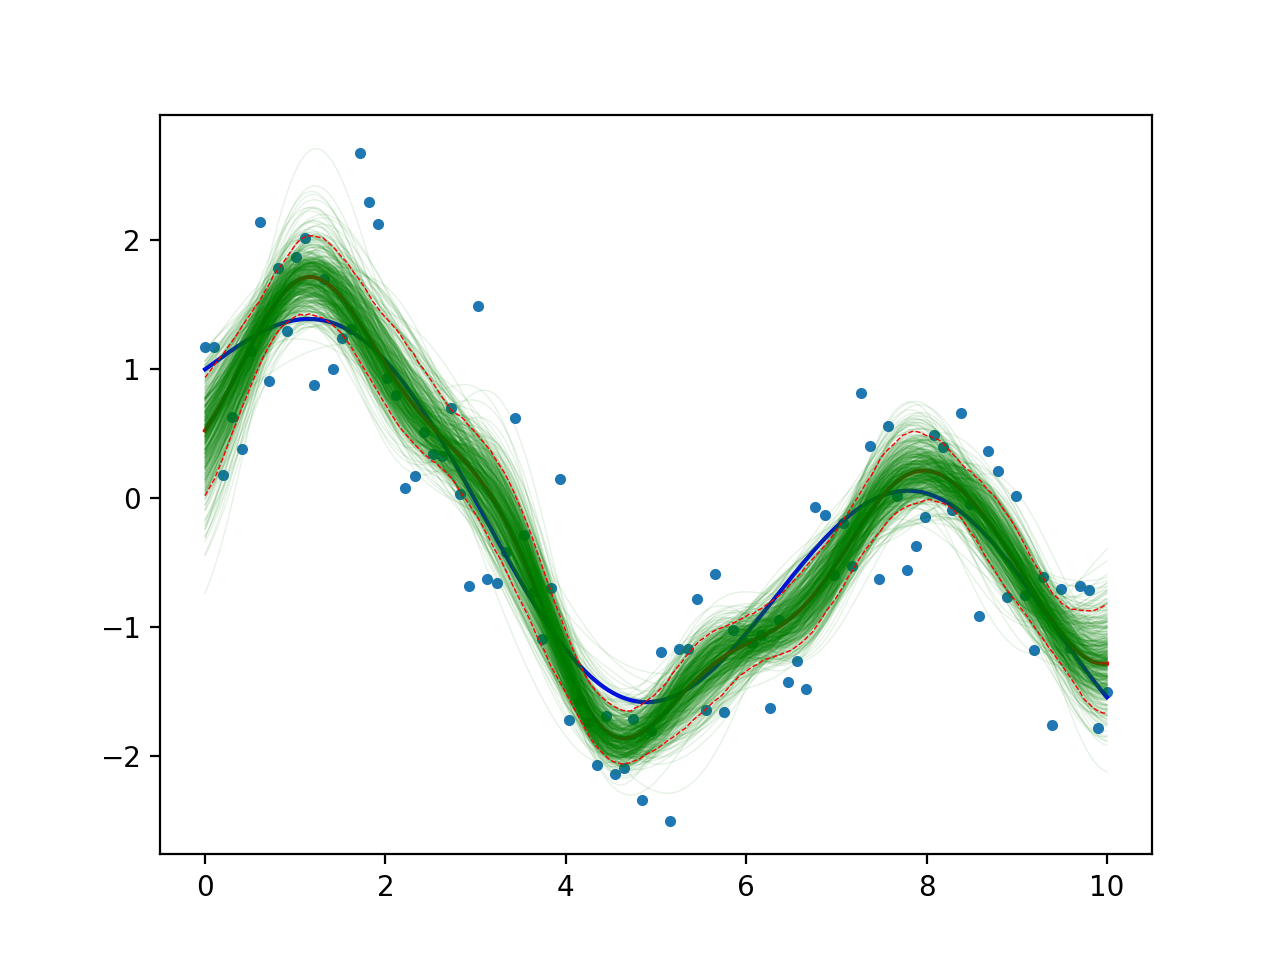

In [28]:
B = 500
inds = np.random.randint(N, size=(N,B))
xB = x[inds]
yB = y[inds]
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
plt.plot(x_test, yht, 'r-')
yhtb_set = np.zeros((B,Nt))
ws = np.zeros((B,D))
for b in range(B):
    Phib = phi(xB[:,b,None], mu[None,:],1)
    wb = np.linalg.lstsq(Phib, yB[:,b],  rcond=1e-12)[0]
    ws[b] = wb
    yhtb = np.dot(Phit, wb)
    yhtb_set[b,:] = yhtb
    plt.plot(x_test, yhtb, 'g-', alpha=.1, linewidth=.5)
lower = np.quantile(yhtb_set, .05, axis=0)
upper = np.quantile(yhtb_set, .95, axis=0)
plt.plot(x_test, lower, 'r--', linewidth=.5)
plt.plot(x_test, upper, 'r--', linewidth=.5)

    

<IPython.core.display.Javascript object>


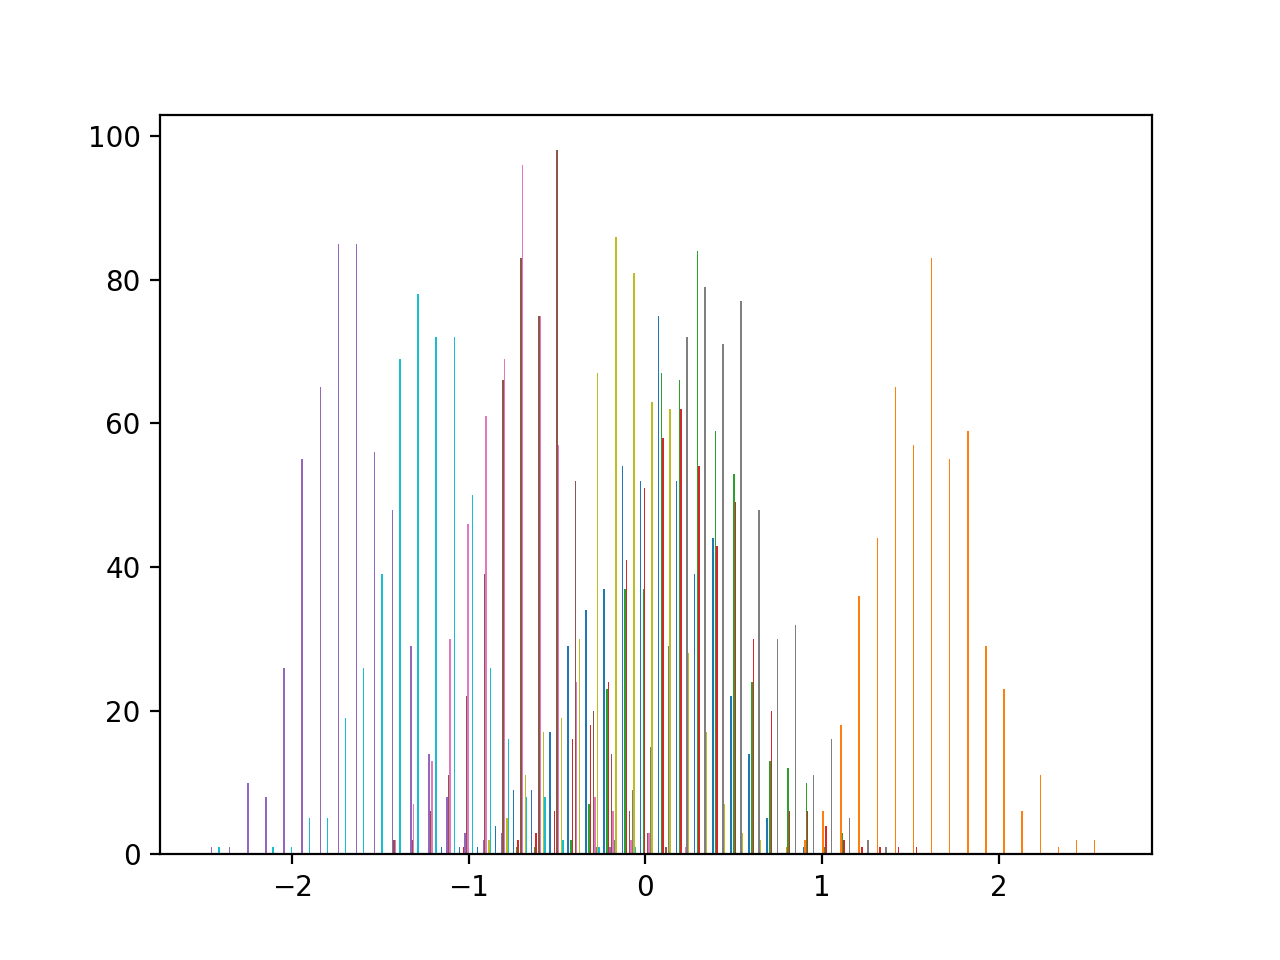

In [24]:
fig, ax = plt.subplots()
plt.hist(ws, bins=50)
plt.show()

Adaptive Bases
=======================

<IPython.core.display.Javascript object>


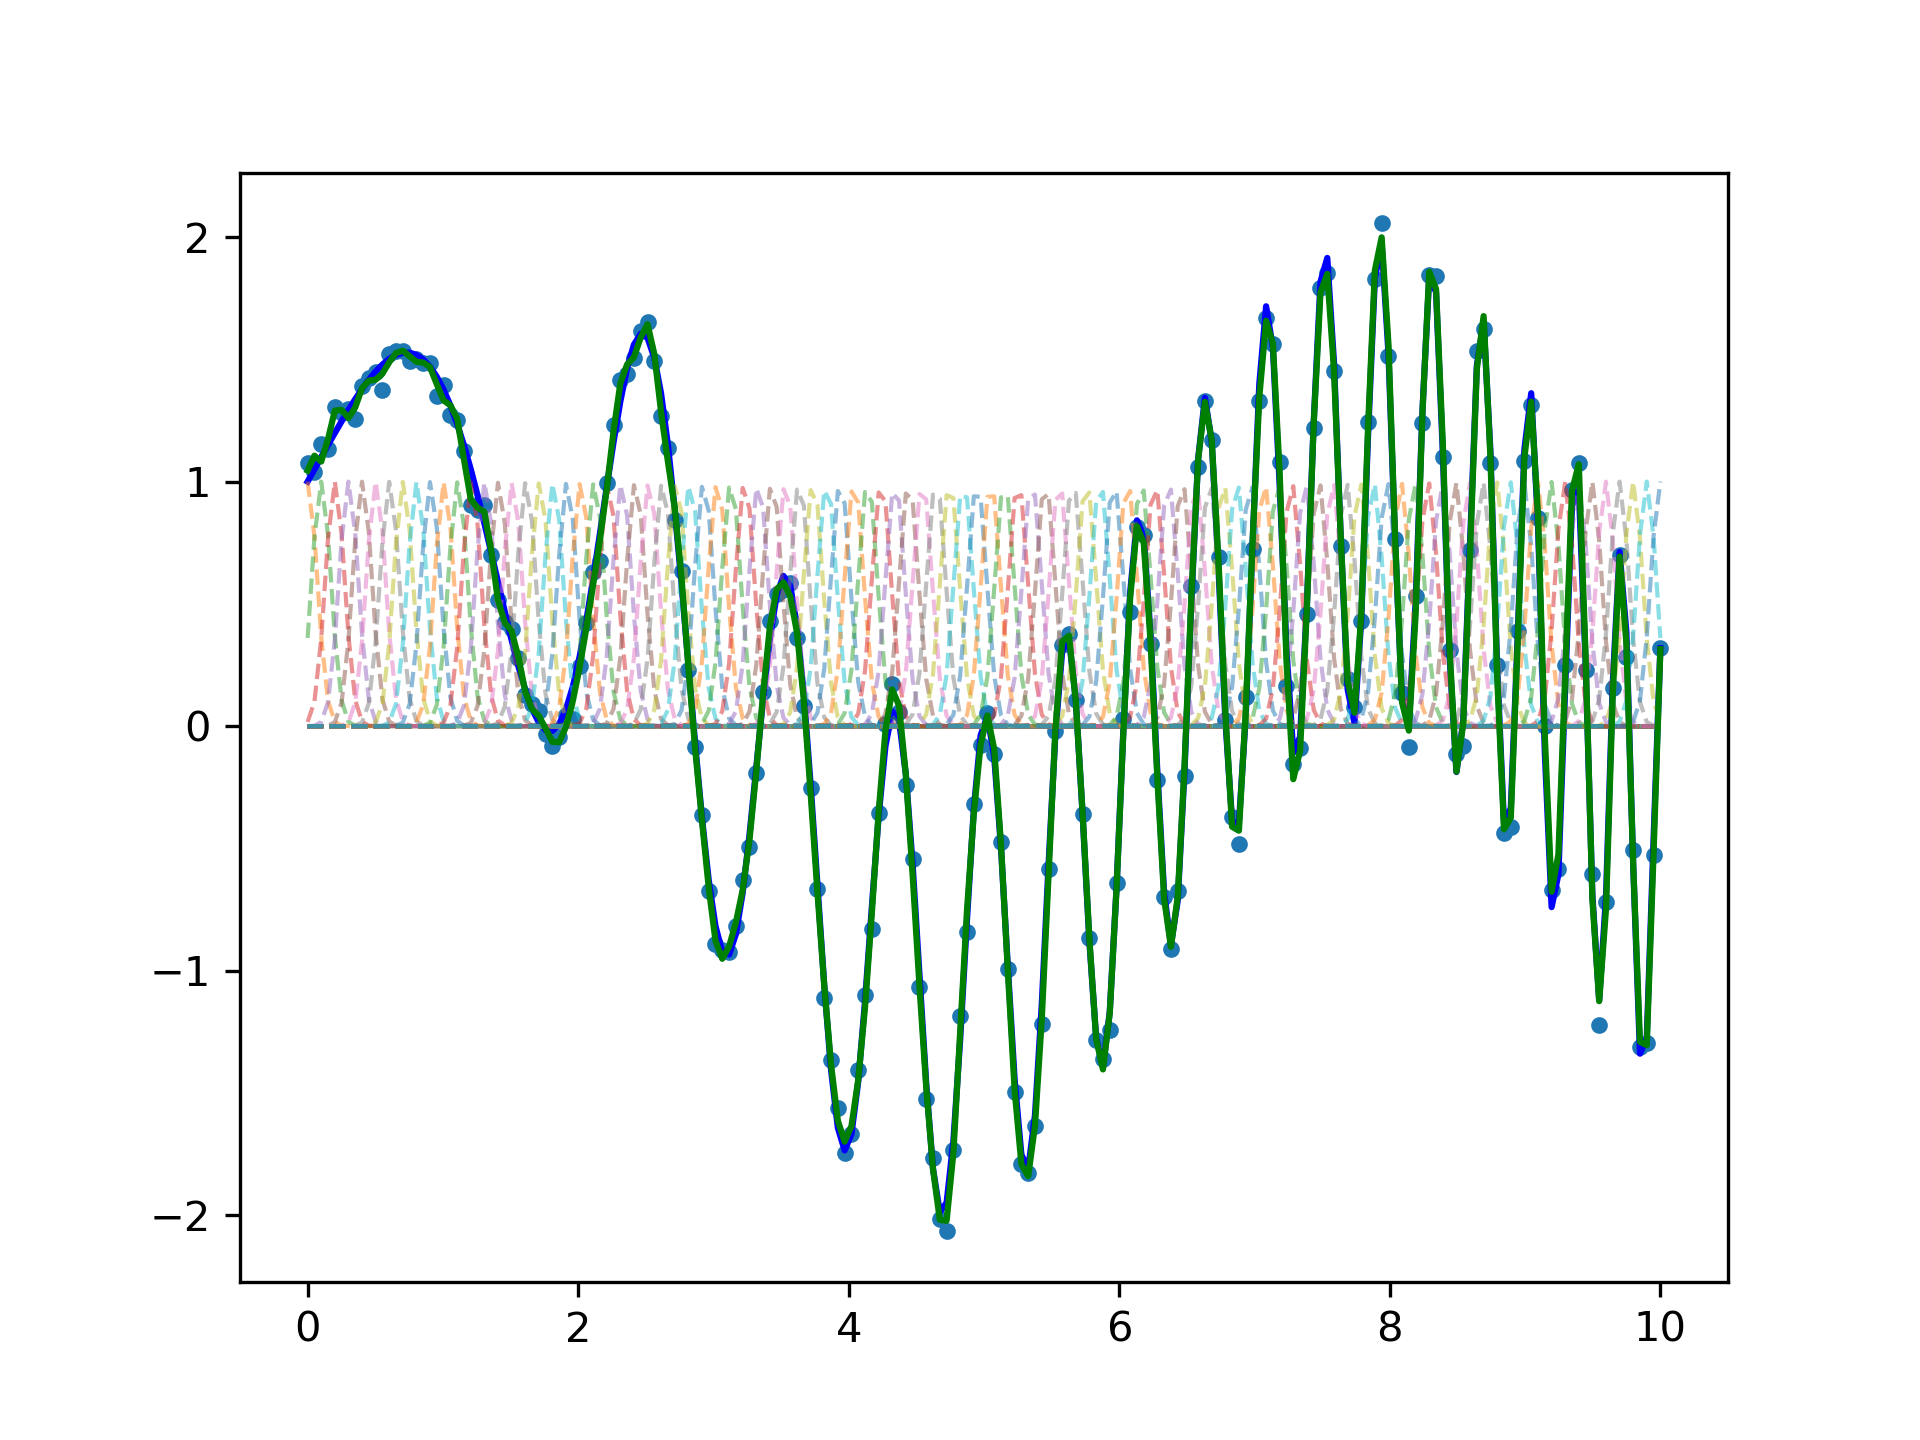

In [142]:
N = 200
Nt = 200
D=100
f = lambda x: np.sin(x) + np.cos(x**2)
x_test = np.linspace(0,10, Nt)
y_test = f(x_test)#np.sin(x_test) + np.cos(x_test**1.5)
x = np.linspace(0,10, N)
yt = f(x) #np.sin(x) + np.cos(x**1.5)
y = yt + .05*np.random.randn(N)
phi = lambda x,mu,sigma: np.exp(-((x-mu)/sigma)**2)
phi2 = lambda x,mu,sigma: 1/(1 + np.exp(-(x - mu)))
mu = np.linspace(0,10,D)
Phi = phi(x[:,None], mu[None,:],.1)
Phit = phi(x_test[:,None], mu[None,:],.1)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
w = np.linalg.lstsq(Phi, y, rcond=1e-10)[0]
yht = np.dot(Phit,w)
for d in range(w.shape[0]):
    plt.plot(x_test, Phit[:,d], '--', alpha=.5, linewidth=1 )
plt.plot(x_test, yht, 'g-')

Radial Basis
-------

In [365]:
def cost(X, y, w, v, phi):
    yh = np.dot(phi(X, v[None,:]), w)
    return np.mean((y - yh)**2)/2

def gradients(X, y, w, v, phi):
    Phi = phi(X, v[None,:])
    yh = np.dot(Phi, w)
    dw= np.dot(Phi.T, yh - y)/N
    dv = -2*np.dot((yh - y), v[None,:] * (v[None,:] - X) * w[None,:] * Phi)/N
    return dw, dv

def SGD(X,y,D, lr=.1,eps=1e-18, max_iters=200000, phi=phi):
    N = X.shape[0]
    w = np.random.randn(D)#np.zeros(D)
    v = np.linspace(0,10, D)
    g = np.inf
    t = 0
    while np.linalg.norm(g) > eps and t < max_iters:
        i = np.random.randint(N, size=(N//4))
        dw, dv = gradients(X[i,:], y[i], w, v, phi)
        #lr = 1./(1+(t**.5))
        w = w - lr*dw
        v = v - lr*dv
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w, v, phi)))

    return w, v



In [366]:
phi2 = lambda x,mu: phi(x,mu,1)
w,mu = SGD(x[:,None],y,D, phi=phi2)
Phi = phi(x[:,None], mu[None,:],1)
Phit = phi(x_test[:,None], mu[None,:],1)

<IPython.core.display.Javascript object>


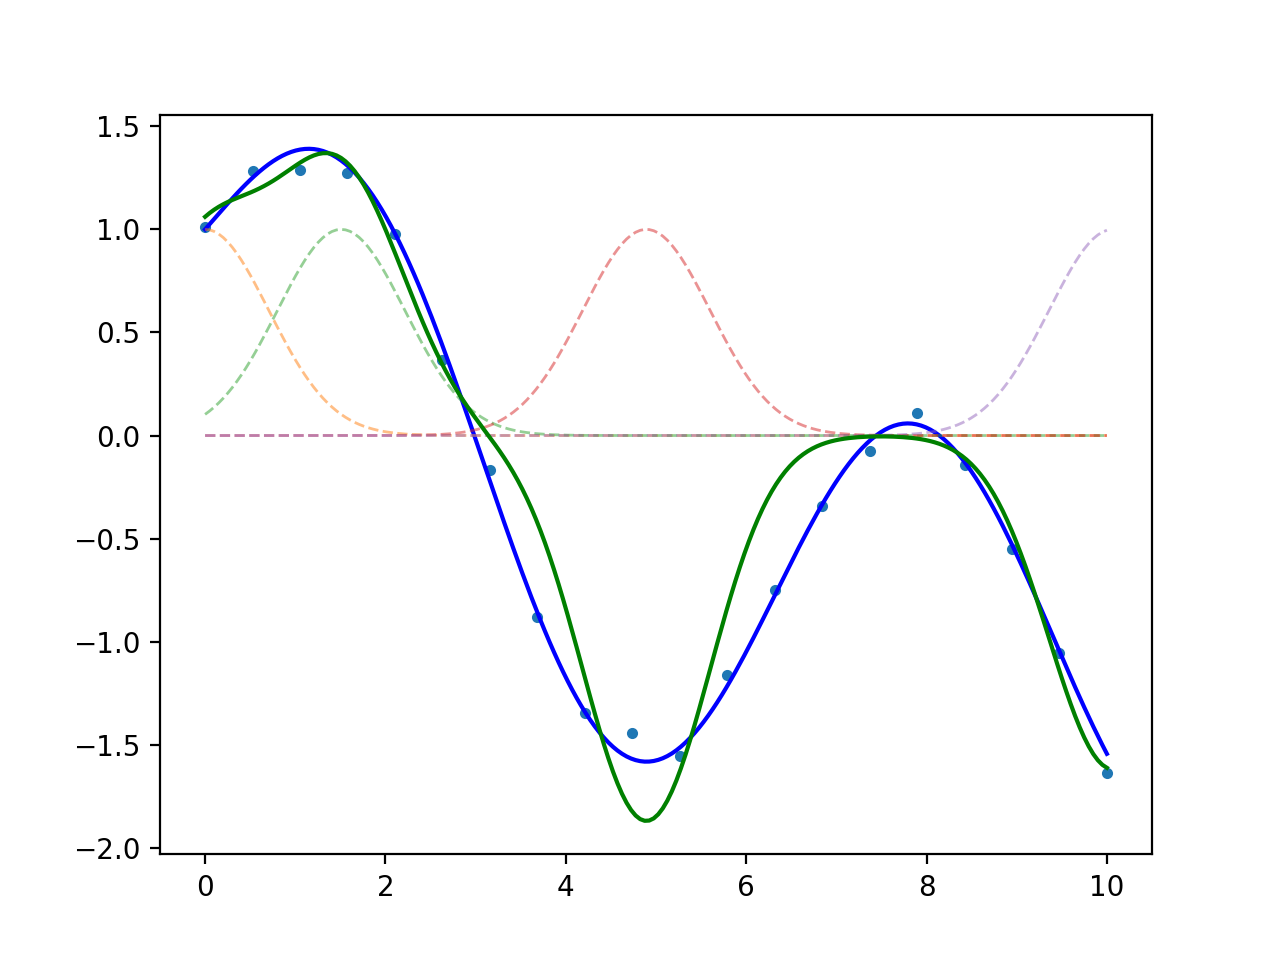

In [367]:
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
yht = np.dot(Phit,w)
for d in range(w.shape[0]):
    plt.plot(x_test, Phit[:,d], '--', alpha=.5, linewidth=1 )
plt.plot(x_test, yht, 'g-')

Neural Net
----------

<IPython.core.display.Javascript object>


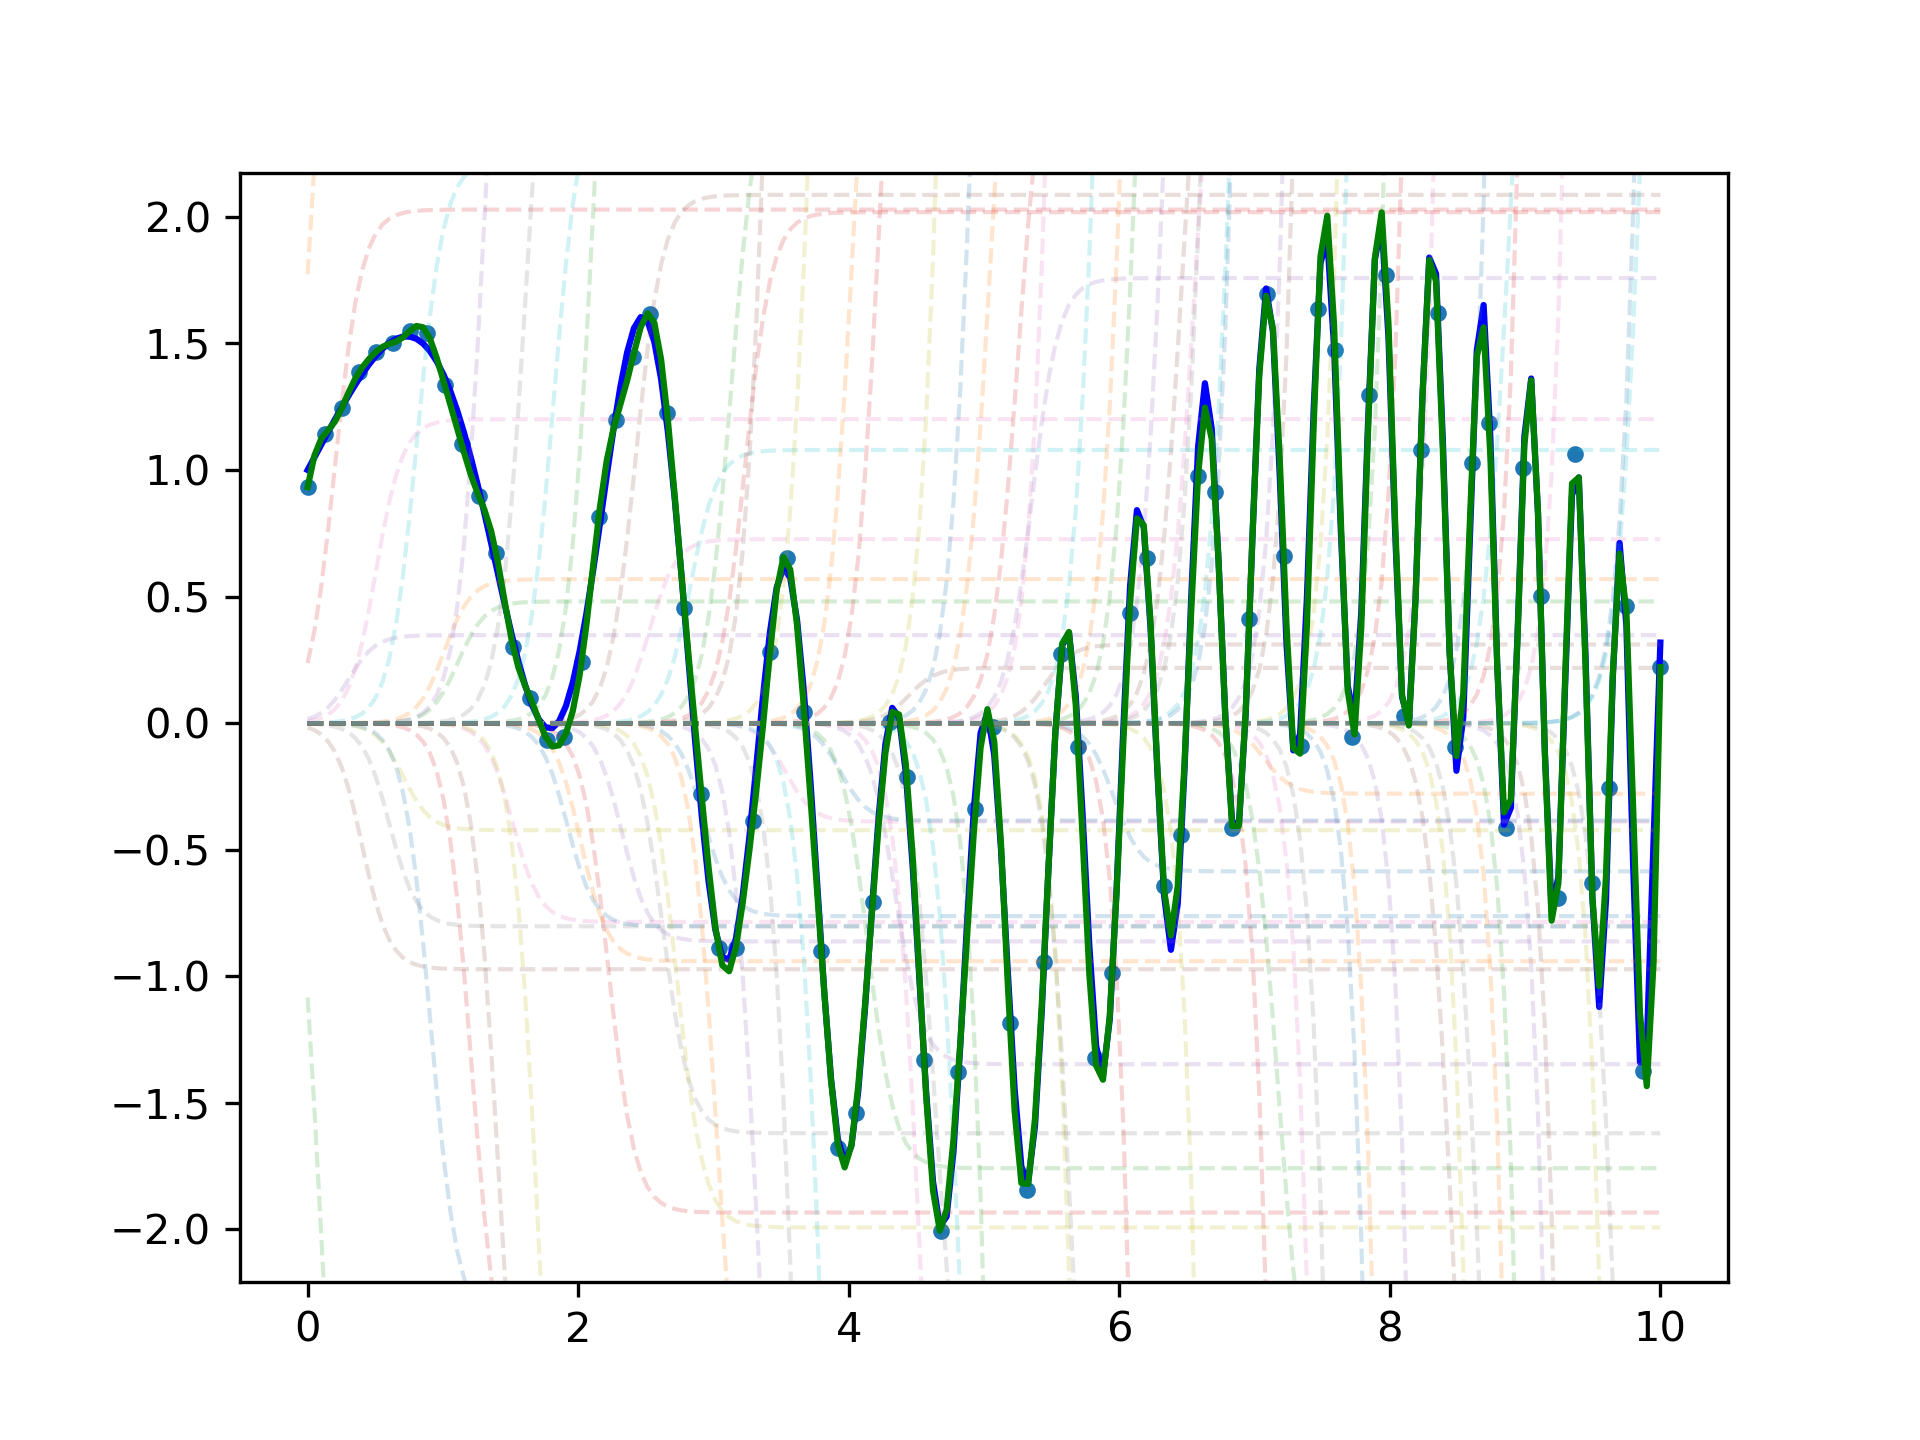

In [157]:
N = 80
Nt = 200
D=100
f = lambda x: np.sin(x) + np.cos(x**2)
x_test = np.linspace(0,10, Nt)
y_test = f(x_test)
x = np.linspace(0,10, N)
yt = f(x)
y = yt + .05*np.random.randn(N)
phi = lambda x,mu,sigma: 1/(1 + np.exp(-10*(x - mu)))
mu = np.linspace(0,10,D)
Phi = phi(x[:,None], mu[None,:],1)
Phit = phi(x_test[:,None], mu[None,:],1)
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
w = np.linalg.lstsq(Phi, y, rcond=1e-10)[0]
yht = np.dot(Phit,w)
plt.autoscale(False)
for d in range(w.shape[0]):
    plt.plot(x_test, Phit[:,d]*w[d], '--', alpha=.2, linewidth=1)
plt.plot(x_test, yht, 'g-')


In [6]:
def cost(X, y, w, v, b, phi):
    yh = np.dot(phi(X, v[None,:], b[None,:]), w)
    return np.mean((y - yh)**2)/2

def gradients(X, y, w, v, b, phi):
    Phi = phi(X, v[None,:], b[None,:])
    N,D = Phi.shape
    yh = np.dot(Phi, w)
    dw= np.dot(yh - y, Phi)/N
    dv = np.dot((yh - y), w[None,:] * X * Phi * (1 - Phi))/N
    db = np.dot((yh - y), w[None,:] * Phi * (1 - Phi))/N
    return dw, dv, db

def SGD(X,y,D, lr=.01,eps=1e-18, max_iters=200000, phi=phi):
    N = X.shape[0]
    w = np.random.randn(D)#*10 #np.zeros(D)
    v = np.random.rand(D)#*10 #np.linspace(0,10, D)
    b = np.ones(D)#*0
    dw = np.inf
    t = 0
    while np.linalg.norm(dw) > eps and t < max_iters:
        i = np.random.randint(N, size=(N))
        dw, dv, db = gradients(X[i,:], y[i], w, v, b, phi)
        #lr = 1./(1+(t**.5))
        w = w - lr*dw
        v = v - lr*dv
        b = b - lr*db
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w, v,b, phi)))
    return w, v, b

def Momentum(X,y,D, lr=.1,eps=1e-18, max_iters=2000000, phi=phi, beta=.9):
    N = X.shape[0]
    w = np.random.randn(D)#*10 #np.zeros(D)
    v = np.random.rand(D)#*10 #np.linspace(0,10, D)
    b = np.ones(D)#*0
    dw, dv, db = 0,0,0
    gw = np.inf
    t = 0
    while np.linalg.norm(gw) > eps and t < max_iters:
        i = np.random.randint(N, size=(N))
        gw, gv, gb = gradients(X[i,:], y[i], w, v, b, phi)
        #lr = 1./(1+(t**.5))
        dw = (1-beta)*gw + beta * dw
        dv = (1-beta)*gv + beta * dv
        db = (1-beta)*gb + beta * db
        w = w - lr*dw
        v = v - lr*dv
        b = b - lr*db
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w, v,b, phi)))
    return w, v, b


<IPython.core.display.Javascript object>


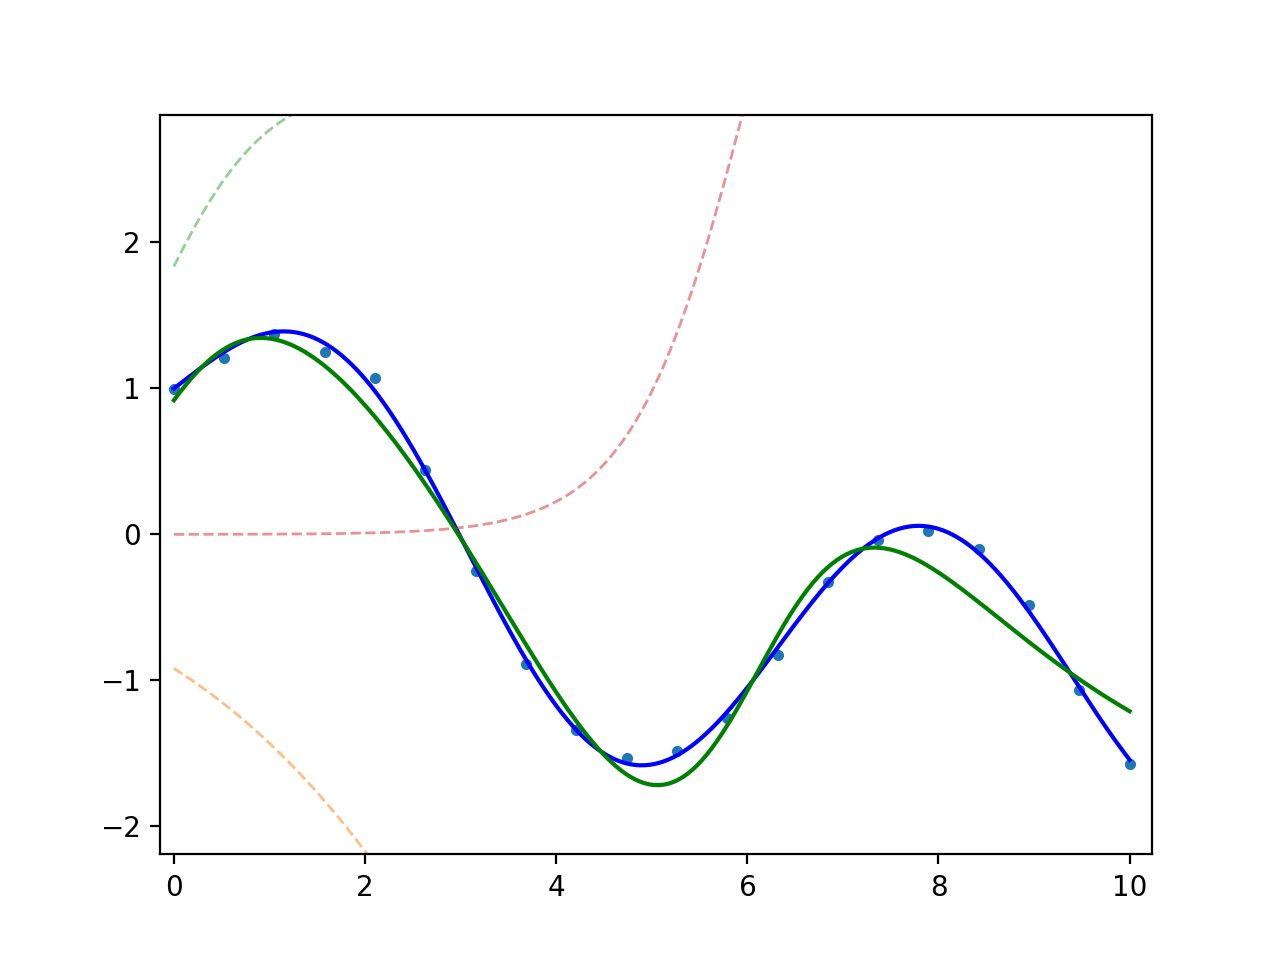

In [7]:
phi3 = lambda x,v,b: 1./(1. + np.exp(-x*v - b))
w,v,b = Momentum(x[:,None],y,D, phi=phi3)
Phi = phi3(x[:,None], v[None,:],b[None,:])
Phit = phi3(x_test[:,None], v[None,:],b[None,:])
fig, ax = plt.subplots()
plt.plot(x, y, '.')
plt.plot(x_test,y_test, 'b-')
yht = np.dot(Phit,w)
for d in range(w.shape[0]):
    plt.plot(x_test, Phit[:,d]*w[d], '--', alpha=.5, linewidth=1)
plt.plot(x_test, yht, 'g-')

In [8]:
from scipy.optimize import check_grad
v0 = np.random.randn(D)
b0 = np.random.randn(D)
w0 = np.random.randn(D)
g = lambda z: cost(x[:,None], y, z, v0, b0, phi3)
g_grad = lambda z: gradients(x[:,None], y, z, v0, b0, phi3)[0]
check_grad(g, g_grad, w0)

1.7391996536466702e-08

Activation functions
=============

<IPython.core.display.Javascript object>


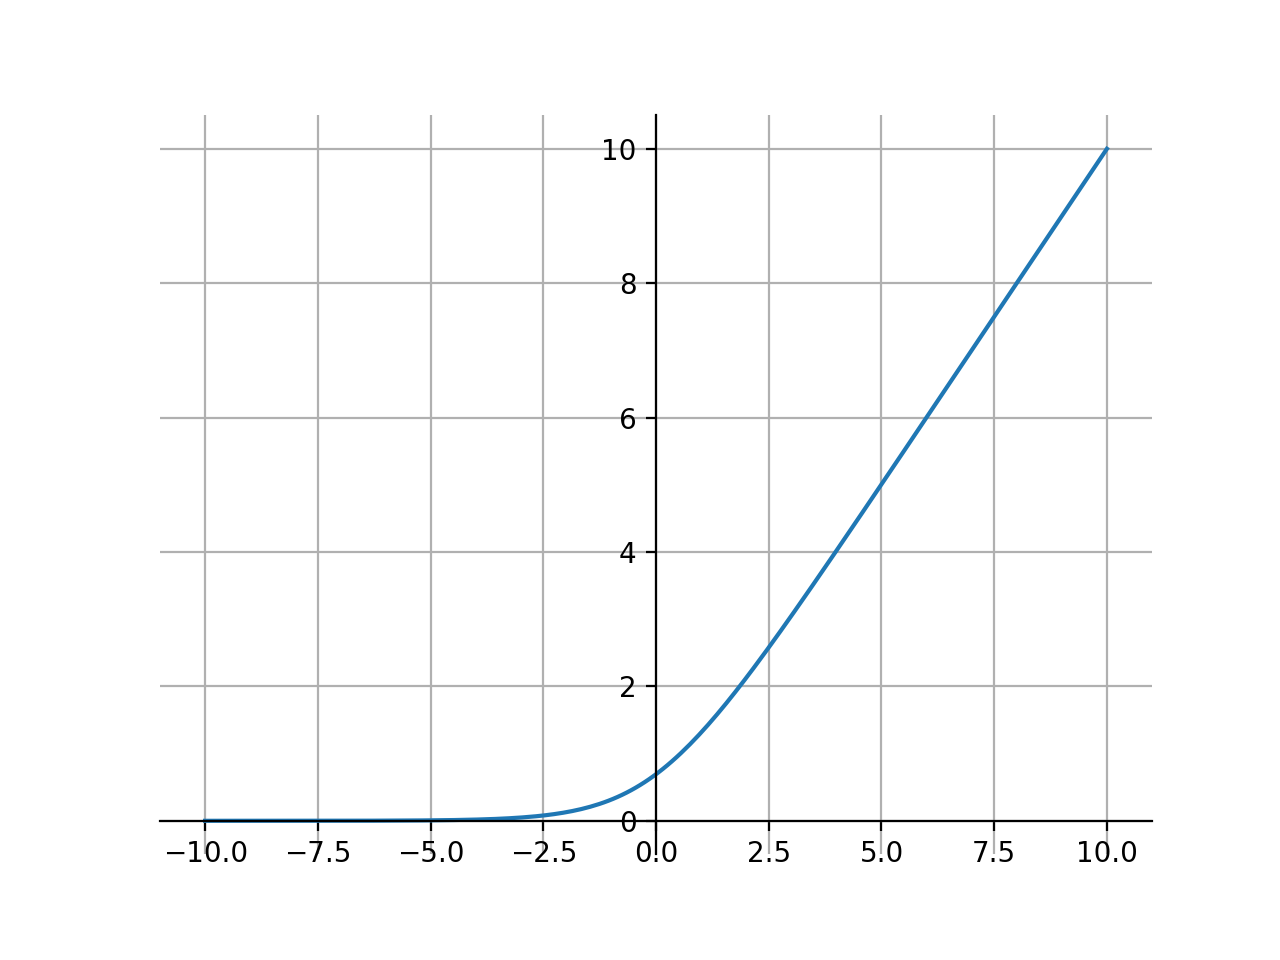

In [19]:

x = np.linspace(-10,10,200)
y = np.log(1+np.exp(x))
fig, ax = plt.subplots()
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_position('zero')
ax.spines['left'].set_position('zero')
ax.spines['right'].set_color('none')
ax.grid()
plt.plot(x, y, '-')

Two-layer general case
===================

In [126]:
def logistic(q):
    return 1 / (1+np.exp(-q))

def softmax(
    q, # N x K
):
    qexp = np.exp(q - np.max(q, 1)[:, None])
    return qexp / np.sum(qexp, axis=-1)[:, None]

def logsumexp(
    Z,# NxK 
):
    Zmax = np.max(Z,axis=1)[:, None]
    lse = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))[:, None]
    return lse #N

def cost(X, #N x D 
         Y, #N x K
         W, #M x K 
         V, #D x M
        ):
    Z = logistic(np.dot(X, V)) #N x M
    U = np.dot(Z, W) #N x K
    Yh = softmax(U)
    nll = - np.mean(np.sum(U*Y, 1) - logsumexp(U))
    return nll

def gradients(X,#N x D
              Y,#N x K
              W,#M x K 
              V,#D x M
             ):
    Z = logistic(np.dot(X, V))#N x M
    N,D = X.shape
    Yh = softmax(np.dot(Z, W))#N x K
    dY = Yh - Y #N x K
    dW= np.dot(Z.T, dY)/N #M x K
    dZ = np.dot(dY, W.T) #N x M
    dV = np.dot(X.T, dZ * Z * (1 - Z))/N #D x M
    return dW, dV

def SGD(X, Y, M, lr=.01, eps=1e-18, max_iters=1000000):
    N, D = X.shape
    N,K = Y.shape
    W = np.random.randn(M, K)*.01
    V = np.random.randn(D, M)*.01
    dW = np.inf*np.ones_like(W)
    t = 0
    print(N,D,M,K) 
    while np.linalg.norm(dW) > eps and t < max_iters:
        i = np.random.randint(N, size=(N))
        dW, dV = gradients(X[i,:], Y[i,:], W, V)
        W = W - lr*dW
        V = V - lr*dV
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w, v,b, phi)))
    return W, V

In [127]:
from scipy.optimize import check_grad
N, D = Xd.shape
N, K = Yd.shape
M = 64
V0 = np.random.randn(D, M)
W0 = np.random.randn(M, K)
print(W0.shape)
g = lambda z: cost(Xd, Yd, W0, np.reshape(z, (D,M)))
g_grad = lambda z: np.reshape(gradients(Xd, Yd, W0, np.reshape(z, (D,M)))[1], (M*D))
check_grad(g, g_grad, np.reshape(V0, (D*M)))

(64, 3)


4.05916282768543e-07

In [128]:
W, V = SGD(Xd, Yd, M)

150 3 64 3


<IPython.core.display.Javascript object>


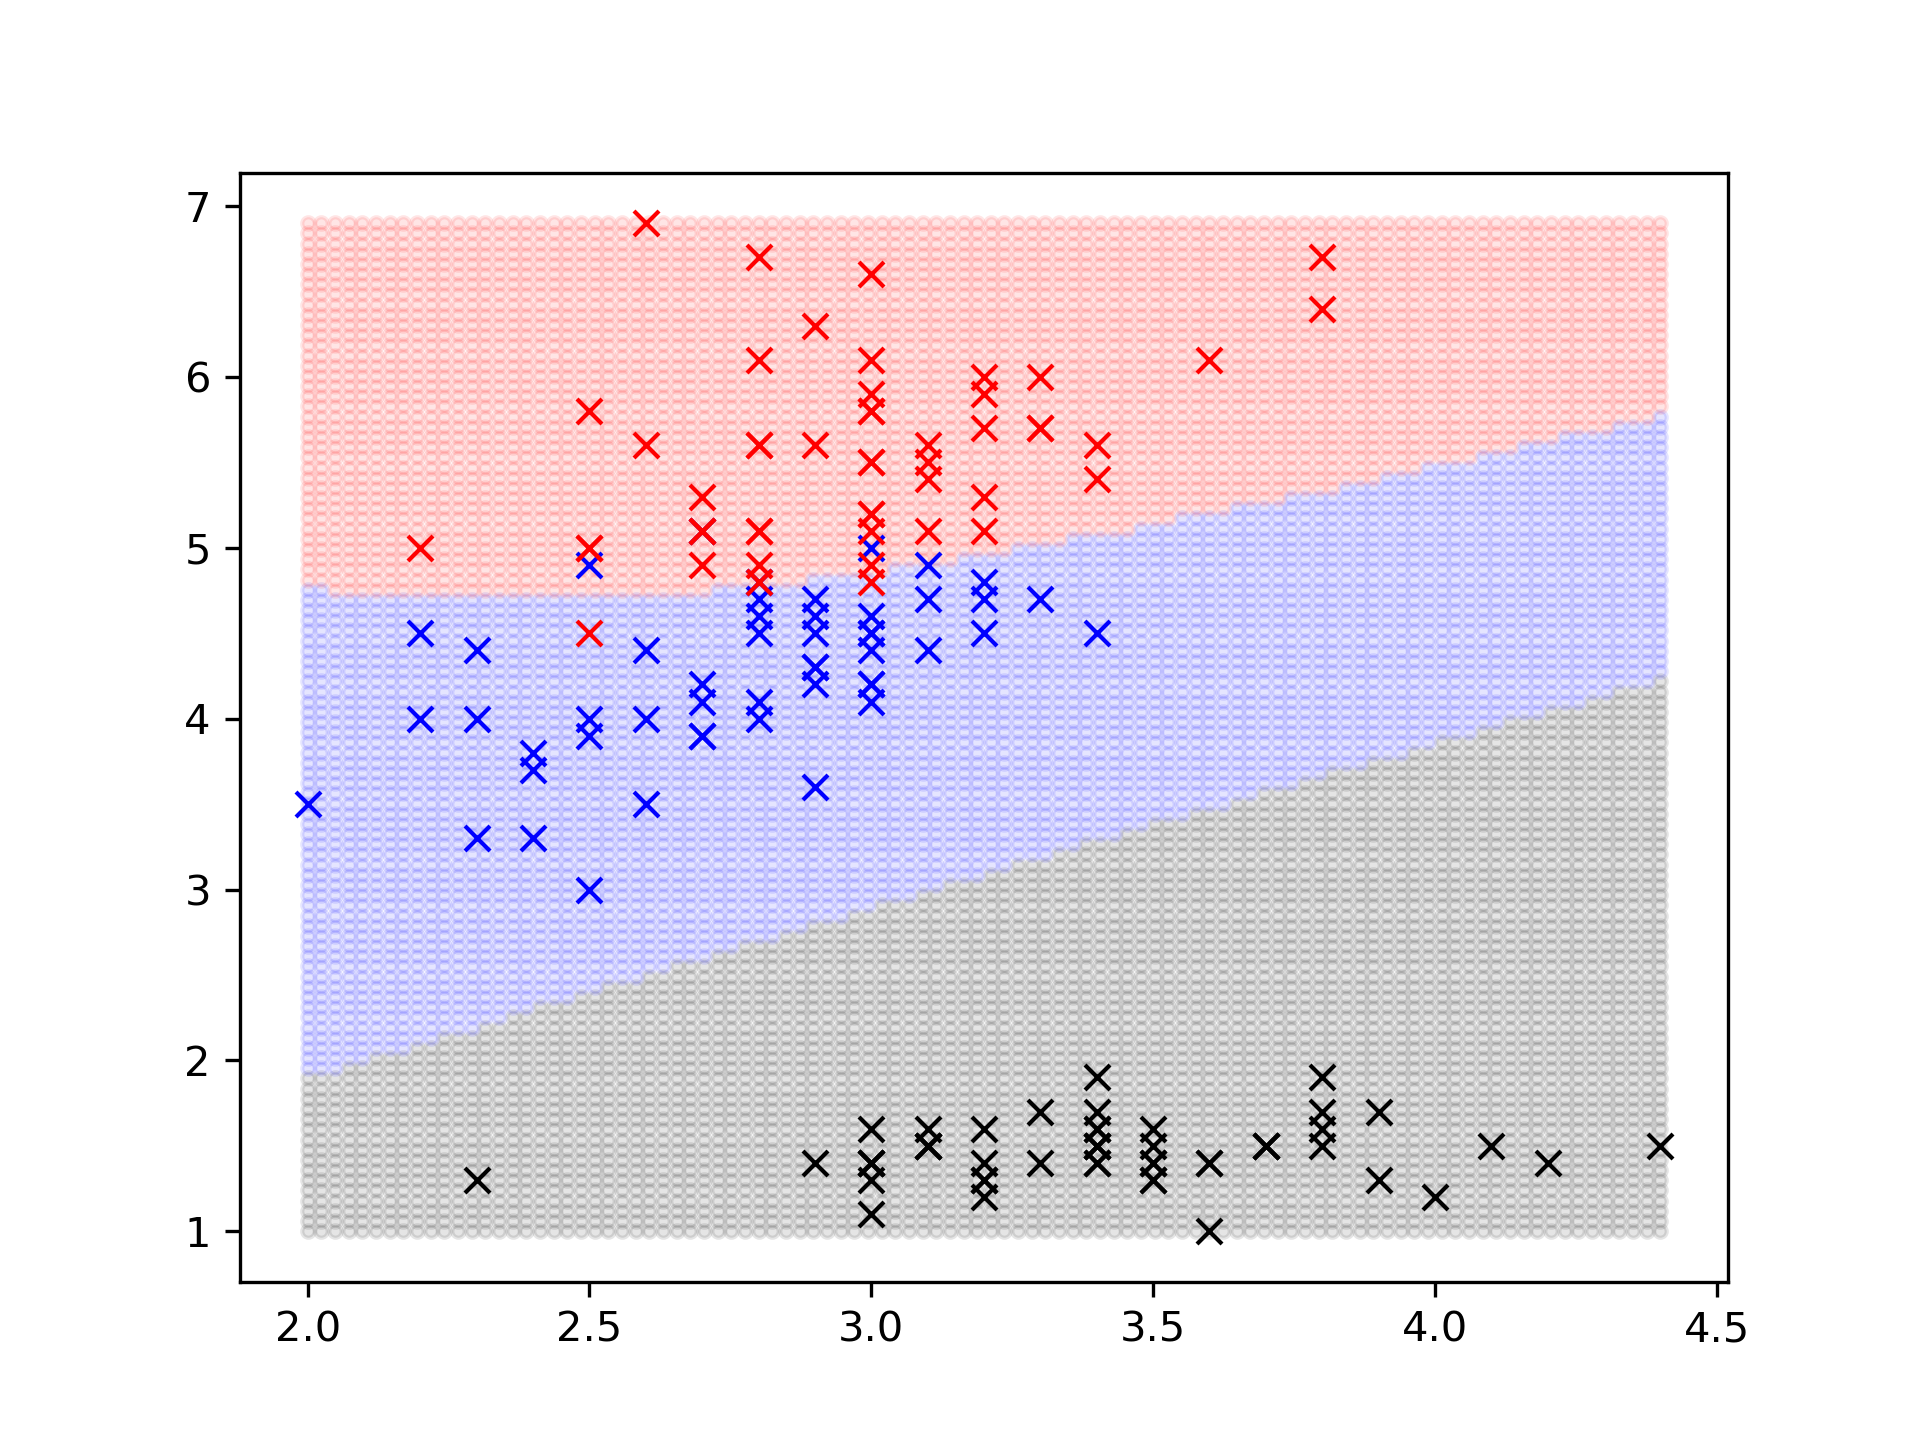

In [129]:
bmin,bmax = np.min(Xd,0), np.max(Xd,0)
xx = np.linspace(bmin[0], bmax[0], 100)
yy = np.linspace(bmin[1], bmax[1], 100)
xv, yv = np.meshgrid(xx, yy)
Xt = np.vstack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()]).T
Yt = softmax(np.dot(logistic(np.dot(Xt, V)), W))
yt = np.argmax(Yt,1)
fig, ax = plt.subplots()

plt.plot(Xt[yt==0,0], Xt[yt==0,1], 'k.', alpha=.1 )
plt.plot(Xt[yt==1,0], Xt[yt==1,1], 'b.', alpha=.1 )
plt.plot(Xt[yt==2,0], Xt[yt==2,1], 'r.', alpha=.1 )

plt.plot(Xd[y==0,0], Xd[y==0,1], 'kx' )
plt.plot(Xd[y==1,0], Xd[y==1,1], 'bx' )
plt.plot(Xd[y==2,0], Xd[y==2,1], 'rx' )



autodiff
===========

In [38]:
import autograd.numpy as np  #
from autograd import grad

def logistic(q):
    return 1 / (1+np.exp(-q))

def softmax(
    q, # N x K
):
    qexp = np.exp(q - np.max(q, 1)[:, None])
    return qexp / np.sum(qexp, axis=-1)[:, None]

def logsumexp(
    Z,# NxK 
):
    Zmax = np.max(Z,axis=1)[:, None]
    lse = Zmax + np.log(np.sum(np.exp(Z - Zmax), axis=1))[:, None]
    return lse #N

def cost(X, #N x D 
         Y, #N x K
         W, #M x K 
         V, #D x M
        ):
    Z = np.maximum(0, np.dot(X, V)) #N x M
    U = np.dot(Z, W) #N x K
    Yh = softmax(U)
    nll = - np.mean(np.sum(U*Y, 1) - logsumexp(U))
    return nll

def gradients(X, #N x D
              Y, #N x K
              W, #M x K 
              V, #D x M
             ):
    Z = logistic(np.dot(X, V)) #N x M
    N,D = X.shape
    Yh = softmax(np.dot(Z, W)) #N x K
    dY = Yh - Y #N x K
    dW = np.dot(Z.T, dY)/N #M x K
    dZ = np.dot(dY, W.T) #N x M
    dV = np.dot(X.T, dZ * Z * (1 - Z))/N #D x M
    return dW, dV

def SGD(X, Y, M, lr=.01, eps=1e-18, max_iters=100000):
    N, D = X.shape
    N,K = Y.shape
    W = np.random.randn(M, K)*.01
    V = np.random.randn(D, M)*.01
    dW = np.inf*np.ones_like(W)
    t = 0
    print(N,D,M,K) 
    cost_param = lambda params: cost(X, Y, params[0], params[1])
    grads = grad(cost_param)
    while np.linalg.norm(dW) > eps and t < max_iters:
        dW, dV = grads([W, V])
        #dW = np.reshape(g[:M*K], (M,K))
        #dW = np.reshape(g[M*K:], (D,M))
        W = W - lr*dW
        V = V - lr*dV
        t += 1
        #print("step:{}  cost:{}".format(t, cost(X,y,w, v,b, phi)))
    return W, V

In [39]:
M = 16
W, V = SGD(Xd, Yd, M)

150 3 16 3


<IPython.core.display.Javascript object>


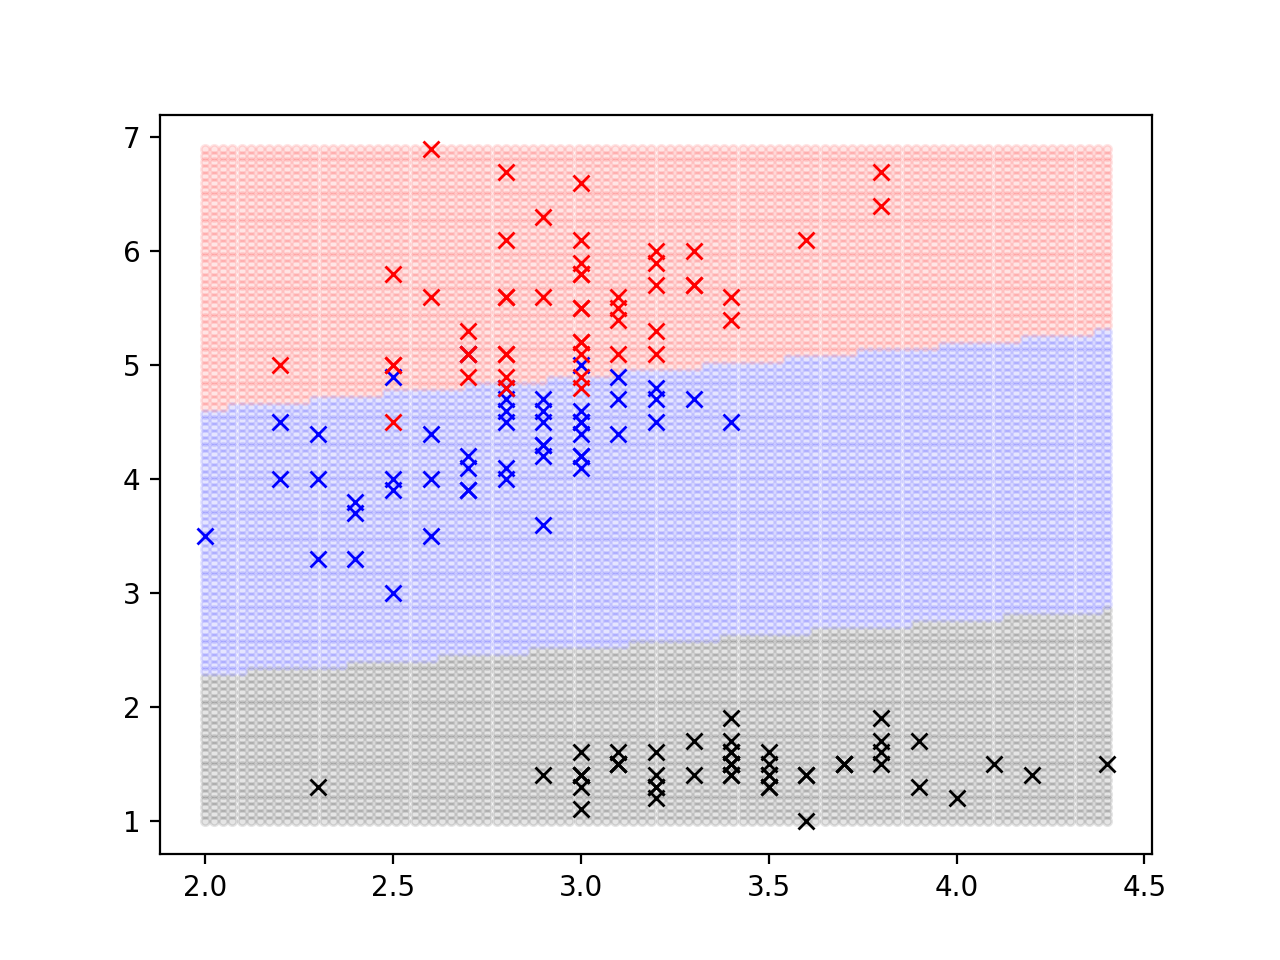

In [40]:
bmin,bmax = np.min(Xd,0), np.max(Xd,0)
xx = np.linspace(bmin[0], bmax[0], 100)
yy = np.linspace(bmin[1], bmax[1], 100)
xv, yv = np.meshgrid(xx, yy)
Xt = np.vstack([xv.ravel(), yv.ravel(), np.ones_like(xv).ravel()]).T
Yt = softmax(np.dot(np.maximum(0,np.dot(Xt, V)), W))
yt = np.argmax(Yt,1)
fig, ax = plt.subplots()

plt.plot(Xt[yt==0,0], Xt[yt==0,1], 'k.', alpha=.1 )
plt.plot(Xt[yt==1,0], Xt[yt==1,1], 'b.', alpha=.1 )
plt.plot(Xt[yt==2,0], Xt[yt==2,1], 'r.', alpha=.1 )

plt.plot(Xd[y==0,0], Xd[y==0,1], 'kx' )
plt.plot(Xd[y==1,0], Xd[y==1,1], 'bx' )
plt.plot(Xd[y==2,0], Xd[y==2,1], 'rx' )

<IPython.core.display.Javascript object>


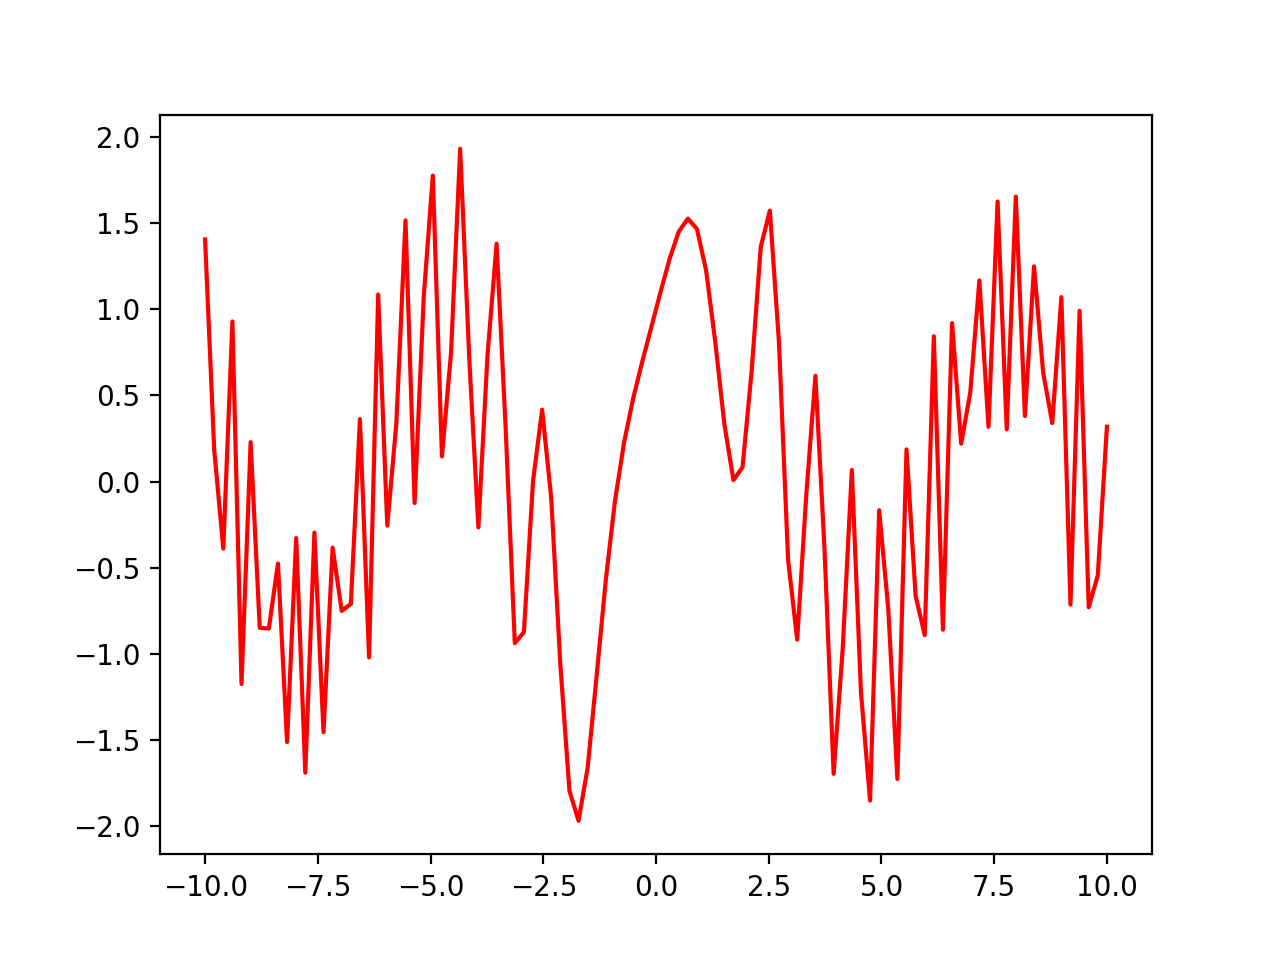

TypeError: Grad only applies to real scalar-output functions. Try jacobian, elementwise_grad or holomorphic_grad.